## SimFlow Hydrological Model

This is a SimFlow (Simple Streamflow) hydrological model that will generate streamflow for small watersheds given temperature and precipitation. Please note that the docstring of all functions were made with the help of ChatGPT.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import pyet
import matplotlib.pyplot as plt

#### Input for the SimFlow

In [2]:
# location = 'seattle'
location = 'chicago'
# location = 'tucson'

In [3]:
meteorological_file = f'/tiger1/msanchit/research/quals_exam/B_data/sim_flow_inputs/{location}/{location}_mt.nc'
basin_file = f'/tiger1/msanchit/research/quals_exam/B_data/sim_flow_inputs/{location}/{location}_basin.nc'
basin_high_res_file = f'/tiger1/msanchit/research/quals_exam/B_data/sim_flow_inputs/{location}/{location}_basin_high_res.nc'
save_output_dir = f'/tiger1/msanchit/research/quals_exam/B_data/sim_flow_results'

In [4]:
# Read the datasets
basin_high_res = xr.open_dataset(basin_high_res_file)
meteorological_ds = xr.open_dataset(meteorological_file)
basin_ds = xr.open_dataset(basin_file)

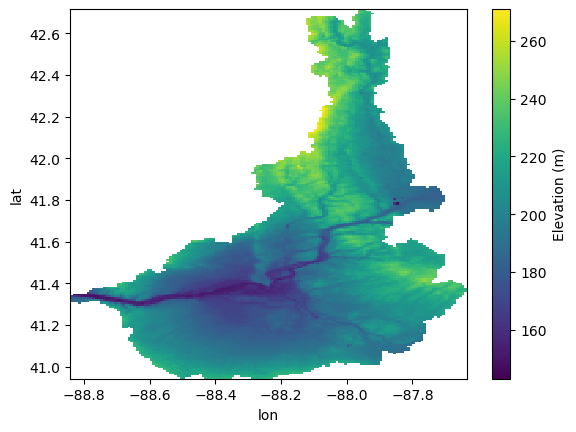

In [5]:
# High Res Basin Version
ax = basin_high_res.elevation.plot(cbar_kwargs={'label': 'Elevation (m)'})

In [6]:
if location == 'seattle':
    ### For Seattle, clay-loam soil
    ## Constant input parameters
    Q_0 = 0.15  # Initial baseflow (m^3/s)
    T_o = 11 # Transmissivity (m^2/day)
    K_s = 0.000254  # Saturated hydraulic conductivity (cm/s)
    phi_ae = 63 # Air entry pressure for soil (cm) 
    b_parameter = 8.52 # Soil parameter (b)
    n_soil_porosity = 0.476 # Soil porosity (n)
    theta_o = 0.17 # Initial soil moisture (volumetric)
    theta_fc = 0.35 # Soil's Field Capacity (volumetric)
    theta_min = 0.12 # Soil's minimum soil moisture, somewhat similar to wilting point (volumetric)
    storm_break_duration = 1 # Duration of storm break to consider a separate storm in days
    fmax = 6 # Max infilteration in a time_step (mm/time_step) i.e. mm/day for this case

    # w_cell_width = 50 # Cell width in m
    # drainage_area = 1000 # Drainage area in m²

In [7]:
if location == 'chicago':
    ### For Chicago, clay soil
    ## Constant input parameters
    Q_0 = 0.0045  # Initial baseflow (m^3/s)
    T_o = 8 # Transmissivity (m^2/day)
    K_s = 0.000128  # Saturated hydraulic conductivity (cm/s)
    phi_ae = 40.5 # Air entry pressure for soil (cm) 
    b_parameter = 11.4 # Soil parameter (b)
    n_soil_porosity = 0.482 # Soil porosity (n)
    theta_o = 0.15 # Initial soil moisture (volumetric)
    theta_fc = 0.4 # Soil's Field Capacity (volumetric)
    theta_min = 0.11 # Soil's minimum soil moisture, somewhat similar to wilting point (volumetric)
    storm_break_duration = 1 # Duration of storm break to consider a separate storm in days
    fmax = 15 # Max infilteration in a time_step (mm/time_step) i.e. mm/day for this case

    # w_cell_width = 50 # Cell width in m
    # drainage_area = 1000 # Drainage area in m²

In [8]:
if location == 'tucson':
    ### For Tucson, fine drained loamy soil
    ## Constant input parameters
    Q_0 = 0.1  # Initial baseflow (m^3/s)
    T_o = 15 # Transmissivity (m^2/day)
    K_s = 0.000254  # Saturated hydraulic conductivity (cm/s)
    phi_ae = 63 # Air entry pressure for soil (cm) 
    b_parameter = 8.52 # Soil parameter (b)
    n_soil_porosity = 0.476 # Soil porosity (n)
    theta_o = 0.08 # Initial soil moisture (volumetric)
    theta_fc = 0.18 # Soil's Field Capacity (volumetric)
    theta_min = 0.06 # Soil's minimum soil moisture, somewhat similar to wilting point (volumetric)
    storm_break_duration = 1 # Duration of storm break to consider a separate storm in days
    fmax = 10 # Max infilteration in a time_step (mm/time_step) i.e. mm/day for this case

    # w_cell_width = 50 # Cell width in m
    # drainage_area = 1000 # Drainage area in m²

In [9]:
## Automatic w_cell_width and drainage_area calculation

n_cells = int(xr.where(basin_ds.elevation == np.nan,0,1).sum())

# Calculate the resolution
lat_res = np.abs(basin_ds.lat[1] - basin_ds.lat[0])  # Latitude resolution (degrees or meters)
lon_res = np.abs(basin_ds.lon[1] - basin_ds.lon[0])  # Longitude resolution (degrees or meters)

# Convert degrees to meters if your data is in lat/lon (for Earth, approx. conversion)
lat_res_meters = lat_res * 111320  # Approximate conversion of 1 degree latitude to meters
lon_res_meters = lon_res * np.mean((111320 * np.cos(np.deg2rad(basin_ds.lat))))  # Varies with latitude
lat_res_meters = np.array(lat_res_meters)
lon_res_meters = np.array(lon_res_meters)

# Cell width in meters
w_cell_width = (lat_res_meters + lon_res_meters)/2

# Drainage area in square meters
drainage_area = (lat_res_meters * lon_res_meters) * n_cells

#### SimFlow Initialization

We will have a model grid where each cell will represent a latitude and longitude point in time. Think of it as 3-D array of shape (time, lat, lon). Each grid cell can have multiple variables like precip, snow_pack, snow_melt etc.

We need a function that can create variables and initialize them in the grid as & when require as it is difficult to list all the variables at once.

In [10]:
# Define the function to add a variable to the grid
def add_variable_to_grid(ds, var_name, initial_value):
    """
    Adds a variable to the grid xarray dataset.
    
    Parameters:
    ds (xarray.Dataset): The  grid dataset to which the variable will be added.
    var_name (str): The name of the new variable.
    initial_value (numeric or array): The initial value for the new variable.
    
    Returns:
    xarray.Dataset: The updated dataset with the new variable.
    """
    # If var_name already exists in the dataset, return the dataset
    if var_name in ds:
        return ds
    
    # Get the available dimensions of the dataset
    dimensions = list(ds.sizes.keys())  # Get the list of dimensions (e.g., ['lat', 'lon'] or ['time', 'lat', 'lon'])
    
    # Initialize shape based on available dimensions
    shape = tuple(ds.sizes[dim] for dim in dimensions)

    # Check the shape of initial_value based on the dimensions of the dataset
    if isinstance(initial_value, np.ndarray):
        if initial_value.shape != shape:
            raise ValueError("initial_value array does not match the dataset's shape")
    else:
        # If initial_value is a scalar, expand it to the dataset's shape
        initial_value = np.full(shape, initial_value)
    
    # Add the variable to the dataset with appropriate dimensions
    ds[var_name] = (dimensions, initial_value)
    # Mask the complete dataset with basin mask
    ds = ds.where(ds.mask == 0)
    
    return ds


#### Converting Precipitation to Rain & Snow

Writing a function to calaculate rain and snow from precipitation based on temperature thresholds.

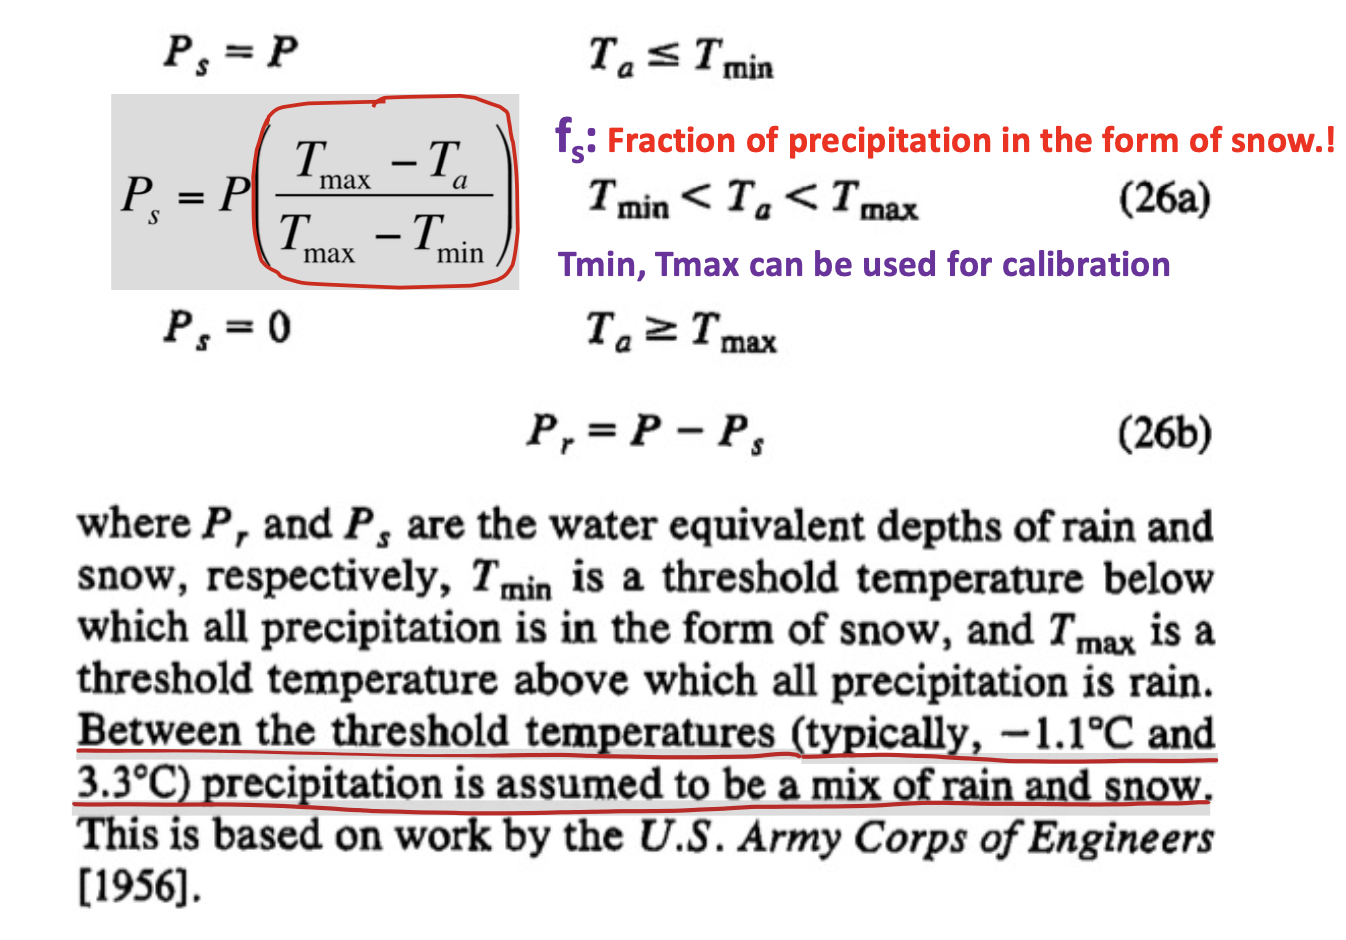

In [11]:
# Define the function to convert precip into rain and snow
def calculate_rain_snow_and_t_avg(ds, t_min_partial_snow=-1.1, t_max_partial_snow=3.3):
    """
    Calculate rain and snow based on temperature thresholds.
    
    Parameters:
    ds (xarray.Dataset): The dataset containing t_min, t_max, and precip variables.
    t_min_partial_snow (float): The temperature below which all precipitation is snow.
    t_max_partial_snow (float): The temperature above which all precipitation is rain.
    
    Returns:
    xarray.Dataset: The updated dataset with calculated rain and snow along with t_avg.
    """
    
    # Calculate the average temperature (t_avg)
    t_avg = (ds['t_min'] + ds['t_max']) / 2
    
    # Initialize snow and rain as empty arrays with the same shape as precip
    snow = xr.zeros_like(ds['precip'])
    rain = xr.zeros_like(ds['precip'])

    # Case 1: If t_avg < t_min_partial_snow, all precip is snow, rain is 0
    mask_snow = t_avg < t_min_partial_snow
    snow = snow.where(~mask_snow, ds['precip'])  # Snow = precip when temp is below threshold
    rain = rain.where(~mask_snow, 0)  # Rain = 0 when temp is below threshold
    
    # Case 2: If t_avg > t_max_partial_snow, all precip is rain, snow is 0
    mask_rain = t_avg > t_max_partial_snow
    snow = snow.where(~mask_rain, 0)  # Snow = 0 when temp is above threshold
    rain = rain.where(~mask_rain, ds['precip'])  # Rain = precip when temp is above threshold
    
    # Case 3: Partial snow and rain when t_min_partial_snow <= t_avg <= t_max_partial_snow
    mask_partial = (t_avg >= t_min_partial_snow) & (t_avg <= t_max_partial_snow)
    snow = snow.where(~mask_partial, ds['precip'] * (t_max_partial_snow - t_avg) / (t_max_partial_snow - t_min_partial_snow))
    rain = rain.where(~mask_partial, ds['precip'] - snow)

    # Mask rain and snow arrays
    rain = rain.where(ds.mask == 0)
    snow = snow.where(ds.mask == 0)
    
    # Add the calculated rain, snow and t_avg to the dataset
    ds['rain'] = rain
    ds['snow'] = snow
    ds['t_avg'] = t_avg
    
    return ds

#### Calculating melt_factor for snow based on Latitude, Season & Given range of melt_factor

Here, we are calculating the melt factor based on latitude, season, and given range of melt factor as per the below equations taken from [Snow-17 Model](https://www.weather.gov/media/owp/oh/hrl/docs/22snow17.pdf). 


Please note that the below melt factor is recommended to use for non-rain melt calculations but for simplicity, we are considering it even for rain-on-snow melt calculations as well. This is because rain-on-snow melt calculations in Snow 17 model are complex and needs extra computation of vapor pressure, wind speed etc. Instead we will be using [Speers et al. (1979)](https://ec-jrc.github.io/lisflood-model/2_04_stdLISFLOOD_snowmelt/) extension of degree-day method.

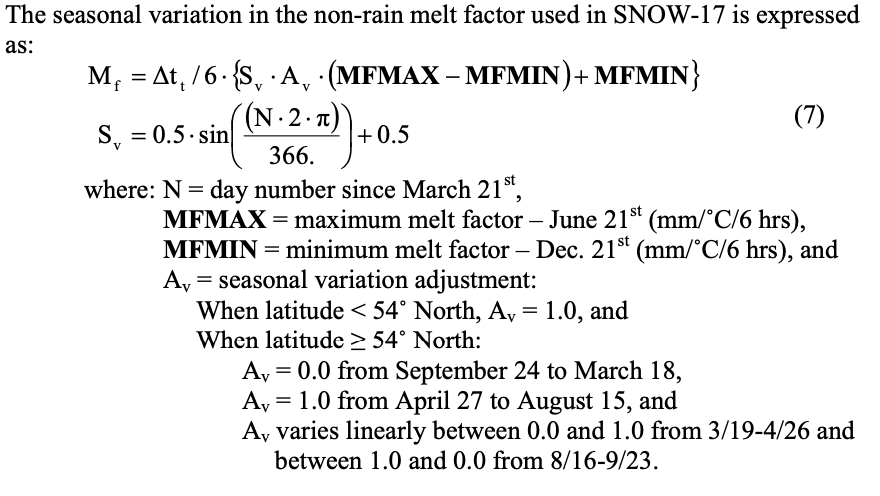

Also note that we are using ∆t_t = 24 for M_f to be in mm/˚C/day.  

In [12]:
# Define the function to calculate the melt factor
def calculate_melt_factor(ds, mf_min=0.5, mf_max=3.0, delta_t_temp=24):
    """
    Calculates the melt factor (M_f) for the model grid based on latitude, time, and seasonal variations.
    
    Parameters:
    ds (xarray.Dataset): The model grid dataset containing time, latitude, and longitude.
    mf_min (float): The minimum melt factor in mm/˚C/6hr.
    mf_max (float): The maximum melt factor in mm/˚C/6hr.
    delta_t_temp (float): Time step between temperature observations in hours, default is 24 hours.
    
    Returns:
    xarray.Dataset: The updated dataset with the 'melt_factor' variable in mm/˚C/delta_t_temp hours. For default it will be mm/˚C/day.
    """

    # Initialize A_v array with the same shape as (time, lat)
    A_v = xr.DataArray(np.zeros((len(ds['time']), len(ds['lat']))), dims=["time", "lat"])

    # Calculate number of days since the preceding March 21 for each date
    time_index = pd.to_datetime(ds['time'].values)
    N_day_since_03_21 = []

    for t in time_index:
        current_year = t.year
        march_21_current_year = pd.Timestamp(f"{current_year}-03-21")

        if t >= march_21_current_year:
            preceding_march_21 = march_21_current_year
        else:
            preceding_march_21 = pd.Timestamp(f"{current_year - 1}-03-21")

        # Calculate the number of days between the preceding March 21 and the current date
        days_since_march_21 = (t - preceding_march_21).days
        N_day_since_03_21.append(days_since_march_21)

    N_day_since_03_21 = np.array(N_day_since_03_21)

    # Calculate seasonal variation S_v over time dimension
    S_v = 0.5 * np.sin((N_day_since_03_21 * 2 * np.pi) / 366) + 0.5

    # Calculate A_v based on latitude and exact date ranges for each year
    for i, t in enumerate(ds['time']):
        for j, lat in enumerate(ds['lat']):
            date = pd.to_datetime(t.values).date()
    
            # Specific date range checks:
            if lat < 54:
                A_v[i, j] = 1  # Latitude below 54 always has A_v = 1
            else:
                if date >= pd.to_datetime('03-19').date() and date <= pd.to_datetime('04-26').date():
                    A_v[i, j] = (date - pd.to_datetime('03-19').date()).days / 38  # Linear from 0 to 1
                elif date >= pd.to_datetime('04-27').date() and date <= pd.to_datetime('08-15').date():
                    A_v[i, j] = 1
                elif date >= pd.to_datetime('08-16').date() and date <= pd.to_datetime('09-23').date():
                    A_v[i, j] = 1 - (date - pd.to_datetime('08-16').date()).days / 39  # Linear from 1 to 0
                else:
                    A_v[i, j] = 0  # Default period (September 24 to March 18)

    # Broadcasting S_v across lat/lon dimensions
    S_v_expanded = np.expand_dims(S_v, axis=(1, 2))  # Expand S_v to match (time, lat, lon) dimensions
    A_v_expanded = np.expand_dims(A_v, axis=2)       # Expand A_v to match (time, lat, lon) dimensions

    # Calculate melt factor M_f (broadcast across lon dimension)
    M_f = delta_t_temp / 6 * (S_v_expanded * A_v_expanded * (mf_max - mf_min) + mf_min)
    
    # Ensure M_f has the correct shape for lon dimension
    M_f = np.array(np.broadcast_to(M_f, (M_f.shape[0], M_f.shape[1], ds.sizes['lon'])))

    # Add or update the 'melt_factor' variable in the dataset
    ds = ds.assign(melt_factor=(["time", "lat", "lon"], M_f))
    
    # Mask the dataarray melt_factor
    ds['melt_factor'] = ds['melt_factor'].where(ds.mask == 0)

    return ds


##### Snow Melt Calculations

As described earlier, for melt calculations we are using [LISFLOOD equation, a variation of Spears et al. (1979)](https://ec-jrc.github.io/lisflood-model/2_04_stdLISFLOOD_snowmelt/) extension of degree-day method. So, we will be using the following equation and here we use meltfactor calculated above in place of Cm+Cs.  
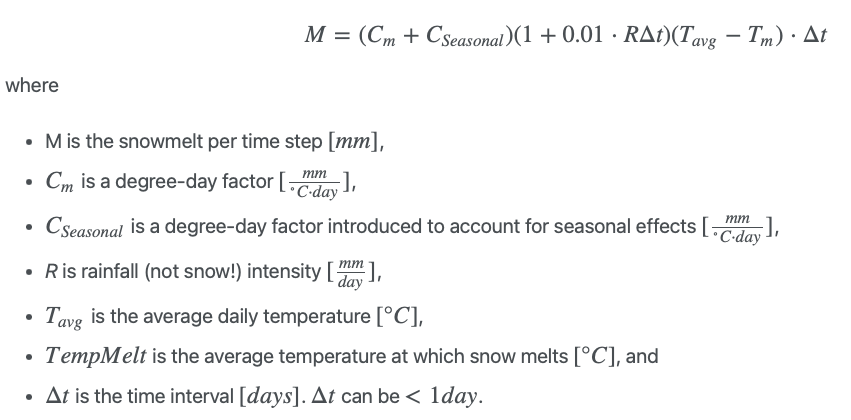

Please note that it does take into account accelerated melt for rain-on-snow scenario but it just assumes for each 1 mm of rainfall, snowmelt increases by 1%. Also, it is might not work best for cases where radiation is a major contributor in snow melt. 

In [13]:
def calculate_snow_melt(ds, delta_t=1, tm=0):
    """
    Calculates the computed snow melt based on melt factor, rain, average temperature,
    and time step.

    Parameters:
    ds (xarray.Dataset): The model grid dataset containing 'melt_factor', 'rain', and 't_avg'.
    delta_t (float): Time step in days, default is 1.
    tm (float): Melt temperature in ˚C, default is 0.

    Returns:
    xarray.Dataset: The updated dataset with the 'snow_melt' variable.
    """

    # Calculate computed snow melt
    computed_snow_melt = ds['melt_factor'] * (1 + 0.01 * (ds['rain'] * delta_t)) * (ds['t_avg'] - tm) * delta_t
    
    # Where computed snow melt is negative, replace it by zero. It is because when t_avg is less than tm, no melting will happen.
    computed_snow_melt = xr.where(computed_snow_melt < 0,0,computed_snow_melt)
    
    # Mask the computed_snow_melt
    computed_snow_melt = computed_snow_melt.where(ds.mask == 0)
    
    # Add or update the 'computed_snow_melt' variable in the dataset
    ds['snow_melt'] = computed_snow_melt

    return ds

#### Calculate Snow Pack & update Snow Melt

In [14]:
def update_snow_pack_swe_and_melt(ds, time_step, water_density=1):
    """
    Calculates the snow pack, snow water equivalent (SWE), and updates the snow melt for a given time step.

    Parameters:
    ds (xarray.Dataset): The model grid dataset containing 'snow_pack', 'snow_melt', and 'snow' variables.
    time_step (int): The current time step (index) for which to update snow pack and melt.
    water_density (float): Density of water in g/cm^3, default is 1.

    Returns:
    xarray.Dataset: The updated dataset with 'snow_pack', 'swe', and recalculated 'snow_melt' in mm.
    """
    
    # Get the current values of snow and snow_melt which will max snow melt that can occur
    current_snow = ds['snow'].isel(time=time_step)
    current_snow_melt = ds['snow_melt'].isel(time=time_step)

    # Determine current_snow_pack based on the time step
    if time_step == 0:
        current_snow_pack = current_snow  # For the first time step, use snow
    else:
        current_snow_pack = ds['snow_pack'].isel(time=time_step - 1) + current_snow  # Add current snow to previous snow pack

    # Determine snow_density based on the time step
    current_snow_density = 0.05 + (0.0017 * ((ds['t_avg'] + 15) ** 1.5))  # in g/cm^3
    
    # Put snow_density as 0.05 where Temperature <= -15
    current_snow_density = current_snow_density.where(ds['t_avg'] > -15, 0.05)
    
    # Calculate snow water equivalent (SWE)
    swe = current_snow_density * current_snow_pack / water_density  # in mm
    
    # Update snow melt
    snow_melt = xr.where(swe >= current_snow_melt, current_snow_melt, swe)
    
    # Update SWE after accounting for snow melt
    updated_swe = swe - snow_melt
    
    # Update the current snow pack after accounting for snow height that melted
    updated_snow_pack = current_snow_pack - (snow_melt * water_density / current_snow_density)
    
    # Mask the snow pack, snow melt and swe
    updated_snow_pack = updated_snow_pack.where(ds.mask == 0)
    snow_melt = snow_melt.where(ds.mask == 0)
    updated_swe = updated_swe.where(ds.mask == 0)

    # Update arrays to replace the old values at this time step
    ds = ds.assign(
        snow_pack=ds['snow_pack'].where(ds['time'] != ds['time'][time_step], updated_snow_pack),
        snow_melt=ds['snow_melt'].where(ds['time'] != ds['time'][time_step], snow_melt),
        swe=ds['swe'].where(ds['time'] != ds['time'][time_step], updated_swe)
    )

    return ds

#### Total Liquid Water

Function to calculate liquid water at each time step.

In [15]:
def calculate_liquid_water(ds, time_step):
    """
    Calculates the liquid water for each grid cell at a given time step.

    Parameters:
    ds (xarray.Dataset): The model grid dataset containing 'snow_melt', 'rain' and 'liquid_water' variables.
    time_step (int): The current time step (index) for which to update liquid water and saturation status.
    
    Returns:
    xarray.Dataset with updated 'liquid_water' at the given time step.
    """

    
    # Get the values at the specified time step
    current_snow_melt = ds['snow_melt'].isel(time=time_step)
    current_rain = ds['rain'].isel(time=time_step)
        
    # Liquid water is the sum of snow melt and rain (in mm)
    liquid_water = current_snow_melt + current_rain
        
    # Update the liquid water for the current time step in the dataset
    ds = ds.assign(
        liquid_water=ds['liquid_water'].where(ds['time'] != ds['time'][time_step], liquid_water)
    )
        
    # Return the updated dataset
    return ds

#### Initial Saturation Status

For calculating saturation status, we use TopModel equations. We will use initial baseflow as an input for the model, so that we can calculate initial saturation status. We are assuming the basin to be in steady state initially.

Here, we will take input as initial baseflow and transmissivity. We can calculate cell width and drainage area as well for the basin and taken them as inputs. It also calculates initial water table depth for both saturated and unsaturated soil.

In [16]:
def calculate_initial_saturation_status_and_water_depth(transmissivity, cell_width, drainage_area, basin_ds, Q_b, K_s):
    """
    Calculates the initial saturation status and water depth aassuming steady statefor each grid cell.

    Parameters:
    transmissivity (float or xarray.DataArray): Transmissivity (T_o) within the saturated soil in m²/day.
    cell_width (float): Width of the cell (m).
    drainage_area (float or xarray.DataArray): Drainage area (A) in m².
    basin_ds (xarray.Dataset): Dataset containing the slope and initially_saturated variable (dimensions lat, lon).
    Q_b (float): Initial baseflow in m^3/s
    K_s (float): Hydraulic conductivity in cm/s.

    Returns:
    Updates the 'initially_saturated' and 'initial_water_table_depth' (in mm) in basin_ds and returns the updated basin_ds.
    """

    # Calculate f which is soil parameter (e-folding depth) in m^-1
    f = K_s * 864 / transmissivity  # Converted K_s from cm/day to m/day as transmissivity is in m^2/day
    
    # Access the slope variable from basin_ds
    slope = basin_ds['slope']  # Assuming the slope variable is named 'slope' with dimensions (lat, lon)

    # calculate recharge from initial base flow and it will be total recharge as well (convert from m³/s to m/day)
    previous_baseflow = Q_b
    recharge = (previous_baseflow / drainage_area) * 86400  # m/s to m/day

    # Calculate 'a' (a = A / cell_width)
    a = drainage_area / cell_width

    # Condition for saturation: a / slope >= transmissivity / recharge (everything in metre and day)
    condition = np.log(a / slope) >= np.log(transmissivity / recharge)

    # Determine saturation status (1 for saturated, 0 for unsaturated)
    saturation_status = xr.where(condition, 1, 0)
    
    # Water table depth
    water_table_depth = xr.where(condition, 0, -1/f * (np.log(recharge) - np.log(transmissivity) + np.log(a/slope)))

    # Mask the water table depth and saturation status
    saturation_status = saturation_status.where(basin_ds.mask == 0)
    water_table_depth = water_table_depth.where(basin_ds.mask == 0)
    
    # update the initially_saturated and initial_water_table_depth variable in basin_ds
    basin_ds['initially_saturated'] = saturation_status
    basin_ds['initial_water_table_depth'] = water_table_depth*1000 # m to mm for water table depth
    
    return basin_ds

#### Initial Soil Moisture

Below is the function to initialize soil moisture. For unsaturated cells, soil moisture will be initialized to theta_o taken as input from the user. For saturated cells, soil moisture will be initialized to porosity, taken as input from the user.

In [17]:
def initialize_soil_moisture(basin_ds, theta_o):
    """
    Initializes soil moisture in the basin dataset based on initial conditions.

    Parameters:
    basin_ds (xarray.Dataset): The basin dataset containing 'initially_saturated'.
    theta_o (float): Initial soil moisture (volumetric) for non-saturated cells.

    Returns:
    xarray.Dataset: The updated basin dataset with initialized soil moisture (volumetric).
    """
    # Create initial soil moisture array based on the condition
    initial_soil_moisture = xr.where(basin_ds['initially_saturated'] == 1, basin_ds['porosity'], theta_o)
    
    # Mask the initial soil moisture
    initial_soil_moisture = initial_soil_moisture.where(basin_ds.mask == 0)

    # Update the basin dataset with the initial soil moisture
    basin_ds['initial_soil_moisture'] = initial_soil_moisture

    return basin_ds

#### Potential Evapotranspiration

Lets calculate potential evapotranspiration and assume it is actual evapotranspiration. Usually actual evapotranspiration is crop factor multiplied by PET, for simplicity it is assumed to be same as PET. Also to keep the model simple (in terms of meteorlogical inputs) and easy, we will use Oudin et al. (2005) method.

Calculate PET by using Oudin et al. (2005) Method and using [pthon package PyEt](https://doi.org/10.5194/gmd-17-7083-2024) as it only needs tempoerature data and simplifies the calculations.

In [18]:
def calculate_PET(ds):
    """
    Calculates the potential evapotranspiration (PET) using the Oudin method.

    Parameters:
    ds (xarray.Dataset): The model grid dataset containing the 't_avg' variable (average temperature in degrees Celsius).

    Returns:
    xarray.Dataset: The updated dataset with the calculated 'PET' variable (in mm/day).

    Notes:
    - The Oudin method requires temperature data ('t_avg') and latitude in radians to calculate PET.
    - PET is calculated in mm/day and added to the dataset as a new variable 'PET'.
    - Latitudes are converted from degrees to radians for the calculation.

    """
    
    latitudes = ds['lat'] * np.pi / 180  # Convert latitudes to radians
    ds['PET'] = pyet.oudin(ds['t_avg'], lat=latitudes)  # Calculate PET using Oudin method
    return ds

#### Storm Duration & Storm Break

Let's track storm duration & storm break so that we can effectively caldulate infiltration rate as infiltration rate decreases with storm duration. Storm duration is believed to be continued if storm's intensity is greater than storm_intensity_threshold for consecutive time steps. For simplicity, storm_intensity_threshold is set to 0 mm but can be changed. The time steps when there is no storm, storm break duration is calculated.

In [19]:
# Function to track storm duration and storm break
def track_storm_duration_and_break(ds, time_step, storm_intensity_threshold=0):
    """
    Tracks storm duration and storm break based on liquid water for a given time step.

    Parameters:
    ds (xarray.Dataset): The dataset containing 'liquid_water', 'storm_duration', 'hortons_storm_duration' and 'storm_break' variables.
    time_step (int): The current time step (index) for which to track storm duration and storm break.
    storm_intensity_threshold (float): The threshold in mm for storm intensity to determine storm duration and storm break.

    Returns:
    xarray.Dataset: The updated dataset with modified 'storm_duration', 'hortons_storm_duration' and 'storm_break' variables.
    """
    
    # Get the liquid water for the current time step
    current_liquid_water = ds['liquid_water'].isel(time=time_step)

    if time_step == 0:
        # For time_step == 0, initialize based on liquid_water
        storm_duration_current = xr.where(current_liquid_water > storm_intensity_threshold, 1, 0)
        storm_break_current = xr.where(current_liquid_water > storm_intensity_threshold, 0, 1)
        hortons_storm_duration = xr.where(current_liquid_water > storm_intensity_threshold, 1, 0)
    else:
        # For time steps greater than 0, calculate based on the previous time step
        storm_duration_previous = ds['storm_duration'].isel(time=time_step-1)
        storm_break_previous = ds['storm_break'].isel(time=time_step-1)

        # If liquid_water > storm_intensity_threshold, increment storm_duration and reset storm_break
        storm_duration_current = xr.where(current_liquid_water > storm_intensity_threshold, storm_duration_previous + 1, 0)
        storm_break_current = xr.where(current_liquid_water > storm_intensity_threshold, 0, storm_break_previous + 1)
        
        # Make storm duration starting from 2 instead of 1 if the previous storm break is less than or equal to 2 days.
        # If storm_duration_current == 1 and storm_break_previous<=2, make hortons_storm_duration to 2
        hortons_storm_duration = xr.where(np.logical_and(storm_duration_current == 1, storm_break_previous <= 2), 
                                  2, storm_duration_current)

    # Mask the data arrays
    storm_duration_current = storm_duration_current.where(ds.mask==0)
    storm_break_current = storm_break_current.where(ds.mask==0)
    hortons_storm_duration = hortons_storm_duration.where(ds.mask==0)
    
    # Update the dataset with the new values for storm_duration and storm_break
    ds = ds.assign(
        storm_duration=ds['storm_duration'].where(ds['time'] != ds['time'][time_step], storm_duration_current),
        storm_break=ds['storm_break'].where(ds['time'] != ds['time'][time_step], storm_break_current),
        hortons_storm_duration=ds['hortons_storm_duration'].where(ds['time'] != ds['time'][time_step], hortons_storm_duration)
    )
    
    return ds

#### Infiltration Rate

Now, since we will have storm duration, we can calculate infiltration rate. As we are trying to find the infiltration rate in mm/timestep and when this timestep is in days, the amount of infiltration rate can be abnormally high. Here a user can use horton's or Green Ampt's infiltration rate or Philip's infiltration rate. All are more reliable for shorter time steps and for now the model is set to use philip's infiltration rate but that can be changed.

Below is the Horton's equation that we used. Please note that horton's infiltration rate is calculated at the end of the time step and that is considered as constant throughout the time step. This is to keep the model simple but can later be updated to represent a better average over the time step.

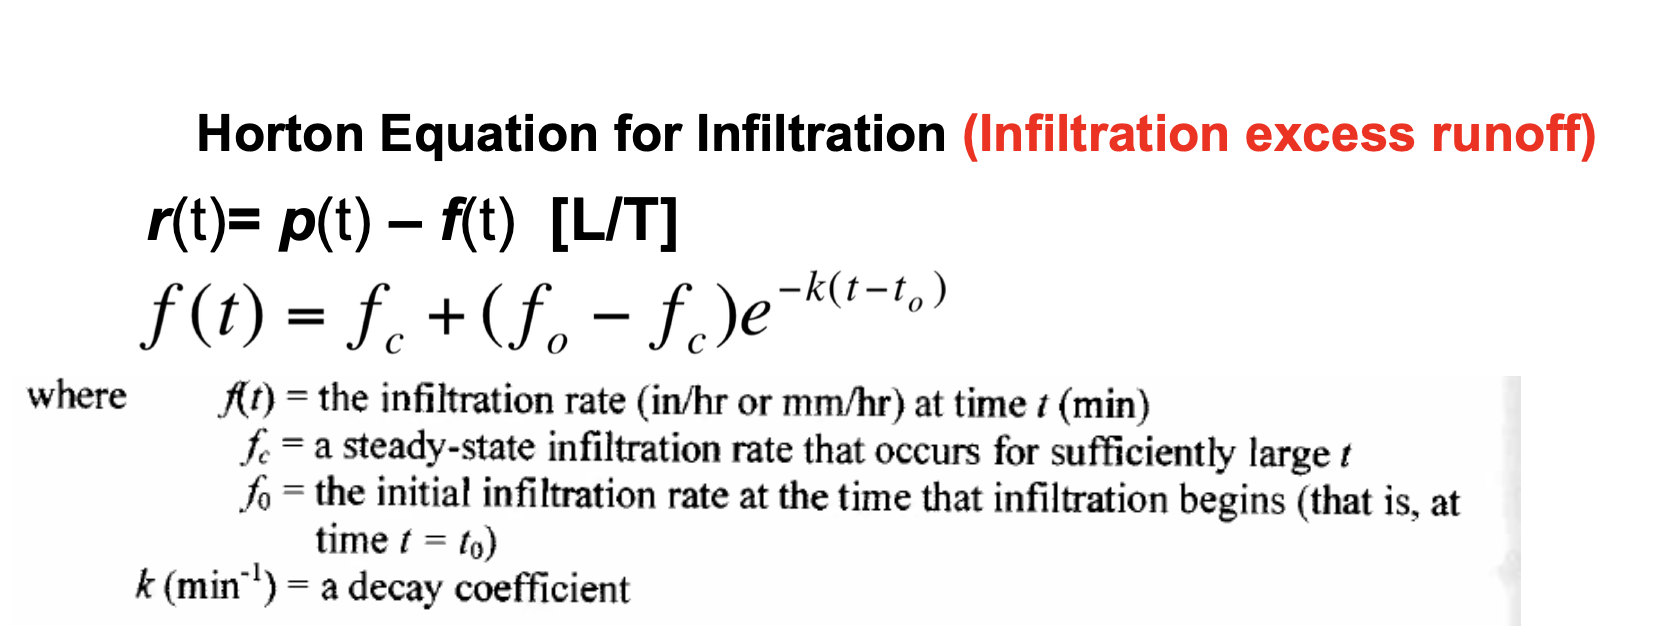

In [20]:
#function to calculate hortons infiltration rate
def compute_hortons_infiltration_rate(ds, time_step, f_c, f_o, k, delta_t=1):
    """
    Computes Horton's infiltration rate for each time step and updates the dataset.

    Parameters:
    ds (xarray.Dataset): The dataset containing 'hortons_storm_duration' variable.
    time_step (int): The current time step (index) for which to compute the infiltration rate.
    f_c (float): Steady-state infiltration rate (mm/hr).
    f_o (float): Initial infiltration rate when infiltration begins (mm/hr).
    k (float): Decay coefficient (min^-1).
    delta_t (float): Time step in days.

    Returns:
    xarray.Dataset: The updated dataset with the computed infiltration rate.
    """
    
    # Time t in minutes since the storm started (Horton's storm duration)
    storm_duration_minutes = ds['hortons_storm_duration'].isel(time=time_step)*delta_t*24*60  # Time in minutes

    # Calculate the infiltration rate f based on the formula. 
    infiltration_rate = xr.where(
        storm_duration_minutes >= 0, 
        f_c + (f_o - f_c) * np.exp(-k * storm_duration_minutes),
        0
    )

    # Convert f from mm/hr to mm/day
    infiltration_rate_mm_per_day = infiltration_rate * 24  # mm/hr to mm/day

    # Update the infiltration rate in the dataset at the current time step
    ds = ds.assign(
        infiltration_rate=ds['infiltration_rate'].where(ds['time'] != ds['time'][time_step], infiltration_rate_mm_per_day)
    )
    
    return ds

Now, lets write a function to calculate infiltration rate for each time step using Green-Ampt equation as shown below

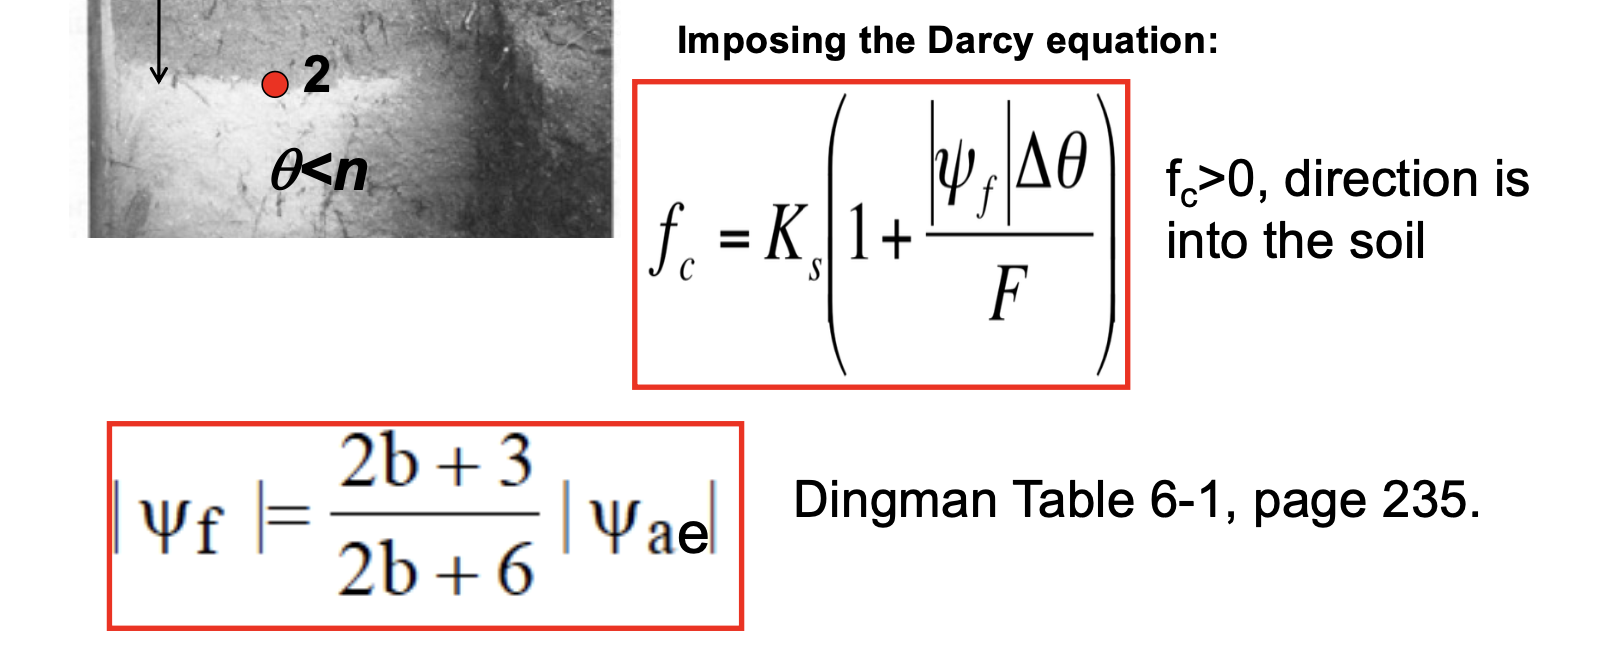

In [21]:
def calculate_infiltration_rate_greenaampt(ds, basin_ds, K_s, phi_ae, b, time_step):
    """
    Calculates the infiltration rate using the Green-Ampt equation.

    Parameters:
    ds (xarray.Dataset): The model grid dataset containing 'cum_infiltration'.
    basin_ds (xarray.Dataset): The basin dataset containing 'porosity' and 'initial_soil_moisture'.
    K_s (float): Hydraulic conductivity in cm/s.
    phi_ae (float): Air entry pressure in cm.
    b (float): Soil parameter.
    time_step (int): The current time step for which to calculate infiltration rate.

    Returns:
    xarray.Dataset: The updated dataset with the calculated infiltration rate in mm/day.
    """
    
    # Calculate phi_f
    phi_f = (2 * b + 3) / (2 * b + 6) * abs(phi_ae) * 10 # convert cm to mm as cum_infiltration is in mm.
    
    # Calculate the infiltration rate (f) based on cumulative infiltration from previous time step or from initial value in case of 0 time step
    if time_step == 0:
        infiltration_rate = K_s * (1 + (phi_f * (basin_ds['porosity'] - basin_ds['initial_soil_moisture']) /
                    ds['cum_infiltration'].isel(time=time_step))) * 864000 # convert cm/s to mm/day
    else:
        infiltration_rate = K_s * (1 + (phi_f * (basin_ds['porosity'] - ds['soil_moisture'].isel(time=time_step-1)) /
                    ds['cum_infiltration'].isel(time=time_step-1))) * 864000 # convert cm/s to mm/day
    
    # Update the dataset with the calculated infiltration rate
    ds = ds.assign(
        infiltration_rate=ds['infiltration_rate'].where(ds['time'] != ds['time'][time_step], infiltration_rate)
    )

    return ds


We used the below Philip's equations. Please note that we used cumulative infiltration to find maximum infiltration that can happen in a time step and calling it as infiltration rate in mm/timestep.

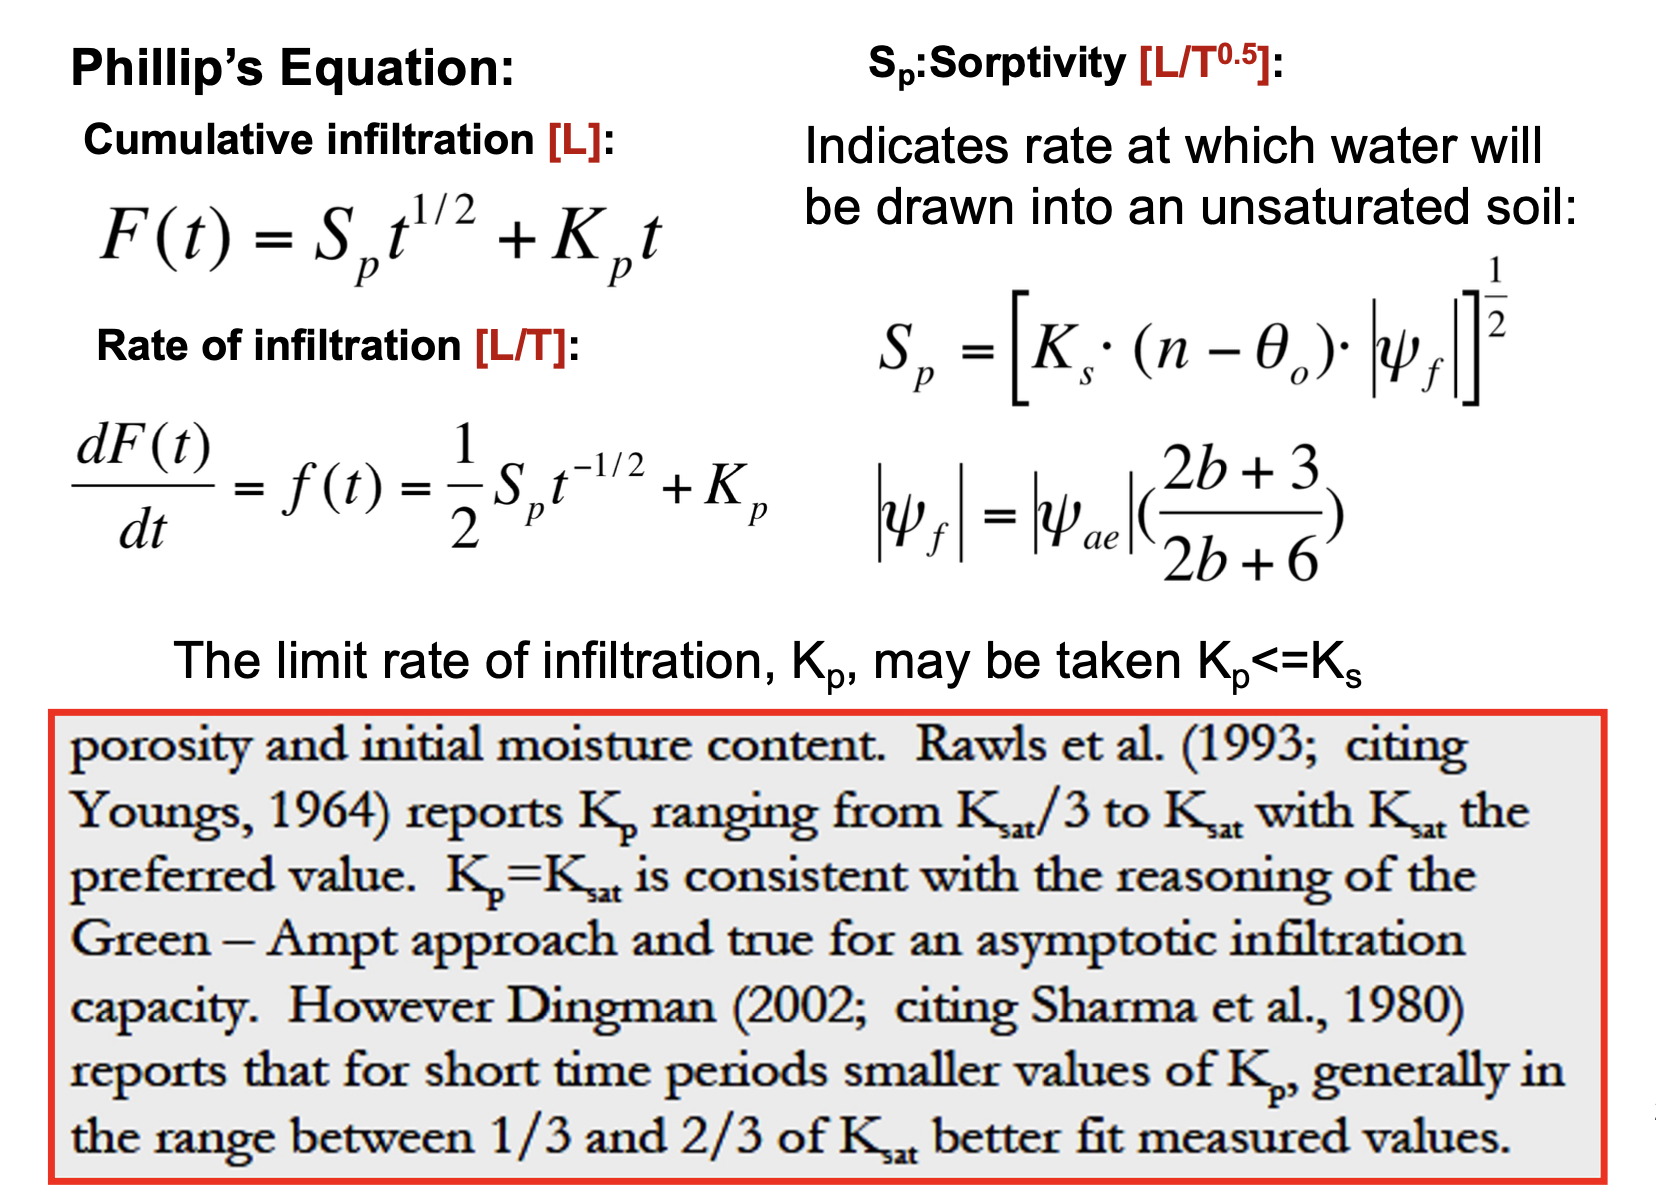

In [22]:
def calculate_infiltration_rate_philips(ds, basin_ds, K_s, phi_ae, b, time_step, delta_t=24, fmax=None):
    """
    Calculates the infiltration rate using the Philips equation.

    Parameters:
    ds (xarray.Dataset): The model grid dataset containing 'cum_infiltration'.
    basin_ds (xarray.Dataset): The basin dataset containing 'porosity' and 'initial_soil_moisture'.
    K_s (float): Hydraulic conductivity in cm/s.
    phi_ae (float): Air entry pressure in cm.
    b (float): Soil parameter.
    time_step (int): The current time step for which to calculate infiltration rate.
    delta_t (float): Time step in hours. Default is 24.
    fmax (float): Maximum infiltration rate in mm/time step.

    Returns:
    xarray.Dataset: The updated dataset with the calculated infiltration rate in mm/day.
    
    Note: K_p (limit rate of infiltration) is taken as K_s.
    """
    
    # Calculate phi_f
    phi_f = (2 * b + 3) / (2 * b + 6) * abs(phi_ae) * 10 # convert cm to mm as cum_infiltration is in mm.
    
    # Assume K_p as K_s
    K_p = K_s * 36000 # Convert cm/s to mm/hr
    
    # Calculate the infiltration rate (f) based on cumulative infiltration from previous time step or from initial value in case of 0 time step
    if time_step == 0:
        # Calculate S_p (Sorptivity)
        S_p = ( K_s * (basin_ds['porosity'] - basin_ds['initial_soil_moisture']) * phi_f * 36000 ) ** 0.5 # convert cm/s to mm/hr
        # Previous storm duration
        previous_storm_duration = 0
        # Previous actual infiltration
        previous_cum_infiltration = 0
    else:
        # Calculate S_p (Sorptivity)
        S_p = ( K_s * (basin_ds['porosity'] - ds['soil_moisture'].isel(time=time_step-1)) * phi_f * 36000 ) ** 0.5 # convert cm/s to mm/hr
         # Previous storm duration
        previous_storm_duration = ds['storm_duration'].isel(time=time_step-1)
         # Previous actual infiltration
        previous_cum_infiltration = ds['cum_infiltration'].isel(time=time_step-1)
    
    # Calculate infiltration (cumulative for a time step), this is the maximum that can  infilter in one time step
    infiltration_max_in_time_step = ((S_p * (ds['storm_duration']*delta_t)**0.5 ) +  ( K_p * (ds['storm_duration']*delta_t) )  -
                          previous_cum_infiltration)    # in mm as (mm/hr) * mm
    
    # Infiltration cannot be negative but since, we are subtratcting cumulative infiltration, it can be negative for storm break times 
    # where storm duration is 0.
    infiltration_max_in_time_step = xr.where(infiltration_max_in_time_step<0, 0, infiltration_max_in_time_step)
    # If fmax given use it create an upper bound
    if fmax:
        infiltration_max_in_time_step = xr.where(infiltration_max_in_time_step>fmax, fmax, infiltration_max_in_time_step)
    
    ## we can also say infiltration rate is in mm/time_step because we are subtracting the infiltration
    
    # Mask the infiltration_max_in_time_step
    infiltration_max_in_time_step = infiltration_max_in_time_step.where(basin_ds.mask==0)
    
    # Update the dataset with the calculated infiltration rate
    ds = ds.assign(
        infiltration_rate=ds['infiltration_rate'].where(ds['time'] != ds['time'][time_step], infiltration_max_in_time_step)
    )

    return ds

#### Baseflow

Below is the formula used to calculate baseflow taken from TopModel.

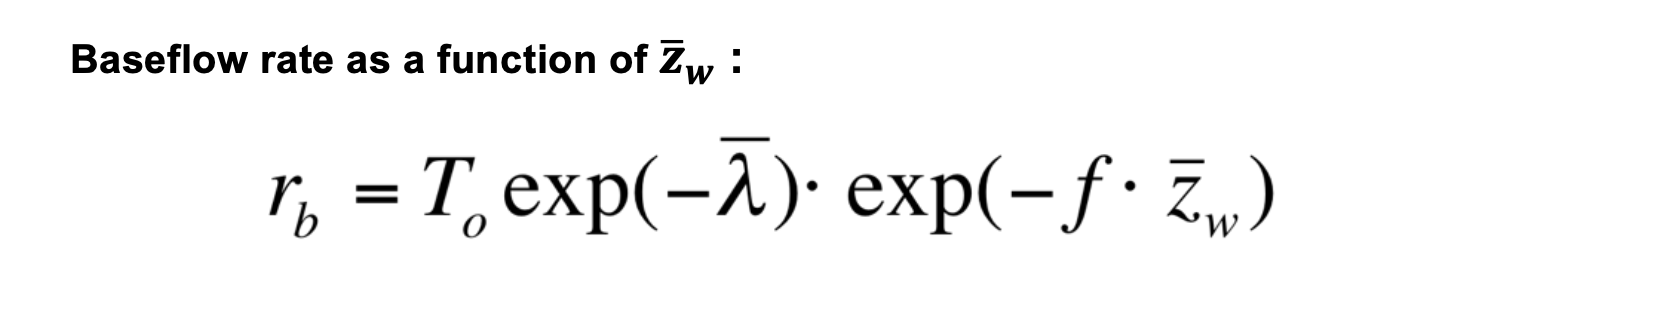

In [23]:
def calculate_baseflow_ts(ds, transmissivity, cell_width, drainage_area, basin_ds, K_s):
    """
    Calculates the baseflow time series for a basin using the mean depth of the water table, 
    transmissivity, slope, and hydraulic properties.

    Parameters
    ----------
    ds : xarray.Dataset
        Dataset containing the 'water_table_depth' variable with dimensions lat, lon, and time.
    transmissivity : float or xarray.DataArray
        Transmissivity (T_o) within the saturated soil layer, given in m²/day.
    cell_width : float
        Width of each grid cell in the basin (meters).
    drainage_area : float or xarray.DataArray
        Drainage area (A) for the basin (square meters).
    basin_ds : xarray.Dataset
        Basin dataset with 'slope' variable across lat, lon.
    K_s : float
        Saturated hydraulic conductivity, given in cm/s.

    Returns
    -------
    baseflow_ts : pandas.Series
        A time series representing the baseflow (m³/s) for the basin, computed at each time step.

    Notes
    -----
    - The function calculates the baseflow using a wetness index approach, which factors in transmissivity, 
      slope, and a decay constant `f` based on hydraulic conductivity.

    Example
    -------
    baseflow_series = calculate_baseflow_ts(ds=hydro_ds, transmissivity=100, cell_width=100, 
                                            drainage_area=50000, basin_ds=basin_data, K_s=0.001)
    """
    # Calculate f which is soil parameter (e-folding depth) in m^-1
    f = K_s * 864 / transmissivity  # Converted K_s from cm/day to m/day as transmissivity is in m^2/day
    
    # Access the slope variable from basin_ds
    slope = basin_ds['slope']  

    # Calculate 'a' (a = A / cell_width)
    a = drainage_area / cell_width   # in m
    
    # Calculate mean wetness index for basin
    mean_WI = np.log(a / slope).mean(dim=['lat', 'lon']).values
    
    # Calculate mean water table depth time series in the basin
    mean_water_table_death_ts = ( ds['water_table_depth'] / 1000).mean(dim=['lat', 'lon']).values # mm to m
    
    # Calculate baseflow timeseries
    baseflow_ts = ( transmissivity * np.exp(-mean_WI) * np.exp( -f * mean_water_table_death_ts ) ) / 86400 # m3/day to m3/s
    
    return baseflow_ts

#### Water Balance

Water Balance at each time step separately for saturated and unsaturated cells. The below function calculates runoff, infiltration, evaporation, change in soil moisture and depth of water table. It then updates the saturation status of each cell in the grid depending on depth of water table.

In [24]:

def water_balance(ds, basin_ds, theta_o, theta_fc, theta_min, time_step, storm_break_duration):
    """
    Update the water balance of a hydrological model grid for a given time step.

    This function computes the changes in water storage and flow in saturated and unsaturated zones 
    based on initial conditions and processes such as infiltration, runoff, evapotranspiration, and 
    cumulative infiltration. The model accounts for soil moisture, water table depth, and saturation status.

    Parameters:
    ----------
    ds : xarray.Dataset
        The dataset containing hydrological variables like soil moisture, water table depth, and 
        saturation status.
    basin_ds : xarray.Dataset
        The dataset containing basin-specific parameters such as porosity and initial conditions.
    theta_o : float
        The steady-state soil moisture content for the top layer (volumetric).
    theta_fc : float
        The field capacity of the soil, above which excess water is considered to contribute to runoff (volumetric).
    theta_min : float
        The minimum soil moisture content that will exist in soil (volumetric).
    time_step : int
        The current time step for which the water balance is being calculated.
    storm_break_duration : int
        Number of days for which storm break should be considered a separate storm and cumulative filtration should be reset to 0.001.

    Returns:
    -------
    xarray.Dataset
        The updated dataset with new values for soil moisture (volumetric), water table depth (mm), saturation status [1/0],
        and other hydrological variables for the specified time step.
    """
    
    #Porosity
    porosity = basin_ds['porosity']
    # Basin Mask
    basin_mask = basin_ds['mask']
    
    # Get the previous time step situation
    if time_step == 0:
        previous_saturation_status = basin_ds['initially_saturated']
        previous_water_table_depth = basin_ds['initial_water_table_depth']
        previous_deficit = basin_ds['initial_deficit']
        previous_soil_moisture = basin_ds['initial_soil_moisture']
        previous_cum_infiltration = ds['cum_infiltration'].isel(time=time_step)
    else:
        previous_saturation_status = ds['saturation_status'].isel(time=time_step-1)
        previous_water_table_depth = ds['water_table_depth'].isel(time=time_step-1)
        previous_deficit = ds['deficit'].isel(time=time_step-1)
        previous_soil_moisture = ds['soil_moisture'].isel(time=time_step-1)
        previous_cum_infiltration = ds['cum_infiltration'].isel(time=time_step-1)
        
    ## For saturated cells
    saturation_condition_with_initial_mask = (previous_saturation_status == 1) & (basin_mask == 0)
    saturated_model_grid_time_step = ds.isel(time=time_step).where(saturation_condition_with_initial_mask)

    #### No infiltration
    saturated_model_grid_time_step['infiltration'] = saturated_model_grid_time_step['infiltration'].where(
                                                    saturated_model_grid_time_step['infiltration'].isnull(),0)
    #### All liquid water will be Runoff
    saturated_model_grid_time_step['runoff'] = saturated_model_grid_time_step['liquid_water']
    #### Reset cumulative infiltration to 0.001 mm if storm is on a break of more than a storm break duration
    storm_break_condition = saturated_model_grid_time_step['storm_break']>=storm_break_duration
    saturated_model_grid_time_step['cum_infiltration'] = xr.where(storm_break_condition,
                        0.001,
                        previous_cum_infiltration+saturated_model_grid_time_step['infiltration'])
    #### cum_infiltration got a new array. Mask it with saturated values in basin
    saturated_model_grid_time_step['cum_infiltration'] = saturated_model_grid_time_step['cum_infiltration'].where(
                                                                            saturation_condition_with_initial_mask)
    #### Evapotranspiration will be equal to potential evapotranspiration
    saturated_model_grid_time_step['ET'] = saturated_model_grid_time_step['PET']
    #### Deficit will be same as evaporation
    saturated_model_grid_time_step['deficit'] = saturated_model_grid_time_step['ET']
    #### Soil Moisture will get updated for top layer to initial soil moisture
    saturated_model_grid_time_step['soil_moisture'] = theta_o
    #### Water Table Depth will be increased
    saturated_model_grid_time_step['water_table_depth'] = previous_water_table_depth + (saturated_model_grid_time_step['ET']
                                                                                            / (porosity - theta_o))
    
    ## For unsaturated cells: 
    unsaturation_condition_with_initial_mask = (previous_saturation_status == 0) & (basin_mask == 0)
    unsaturated_model_grid_time_step = ds.isel(time=time_step).where(unsaturation_condition_with_initial_mask)
    
    #### Evapotranspiration
    unsaturated_model_grid_time_step['ET'] = unsaturated_model_grid_time_step['PET']
    
    #### Update previous deficit as evapotranspiration will have create more space for infiltration
    previous_deficit =  previous_deficit + unsaturated_model_grid_time_step['ET']
    
    #### Infiltration will be either liquid_water or infiltration rate or deficit whatever is minimum
    unsaturated_model_grid_time_step['infiltration'] = np.minimum(
                                                    previous_deficit, 
                                                    np.minimum(unsaturated_model_grid_time_step['liquid_water'], 
                                                                unsaturated_model_grid_time_step['infiltration_rate']))
    
    #### Runoff wil bely liquid_water - infiltration. If negative set to 0.
    unsaturated_model_grid_time_step['runoff'] = ( unsaturated_model_grid_time_step['liquid_water'] - 
                                                  unsaturated_model_grid_time_step['infiltration'])
    unsaturated_model_grid_time_step['runoff'] = unsaturated_model_grid_time_step['runoff'].where(
                                                    unsaturated_model_grid_time_step['runoff'] > 0, 0)
    
    #### Add infiltration to previous cumulative infiltration  or reset it if storm break is of more than a day
    storm_break_condition = unsaturated_model_grid_time_step['storm_break']>=storm_break_duration
    unsaturated_model_grid_time_step['cum_infiltration'] = xr.where(storm_break_condition,
                        0.001,
                        previous_cum_infiltration+unsaturated_model_grid_time_step['infiltration'])
    #### cum_infiltration got a new array. Mask it with unsaturated values in basin
    unsaturated_model_grid_time_step['cum_infiltration'] = unsaturated_model_grid_time_step['cum_infiltration'].where(
                                                                            unsaturation_condition_with_initial_mask)
    
    #### Update deficit after infiltration again as it will get decrease by the infiltrated amount. If negative, set to 0
    unsaturated_model_grid_time_step['deficit'] = previous_deficit - unsaturated_model_grid_time_step['infiltration']
    unsaturated_model_grid_time_step['deficit'] = unsaturated_model_grid_time_step['deficit'].where(
                                                    unsaturated_model_grid_time_step['deficit'] > 0, 0)
    
    #### Soil Moisture will get increase due to addition of infiltered water but will decrease due to evaporated water
    #### First calculating soil moisture assuming no change in water table depth
    #### deficit represents air space in soil. So porosity - new air space = new water space as previous deficit already takes care of E & I
    unsaturated_model_grid_time_step['water_table_depth'] = previous_water_table_depth
    unsaturated_model_grid_time_step['soil_moisture'] = ((previous_soil_moisture*previous_water_table_depth) + 
                                                         unsaturated_model_grid_time_step['infiltration'] -
                                                         unsaturated_model_grid_time_step['ET']) / previous_water_table_depth

    #### Note that soil moisture will never be more than porosity as deficit will never be negative. And water table depth will be zero.
    unsaturated_model_grid_time_step['water_table_depth'] = unsaturated_model_grid_time_step['water_table_depth'].where(
                                                        unsaturated_model_grid_time_step['soil_moisture']< porosity,0)
    unsaturated_model_grid_time_step['soil_moisture'] = unsaturated_model_grid_time_step['soil_moisture'].where(
                                                        unsaturated_model_grid_time_step['soil_moisture']< porosity,porosity)

    #### Extreme Dry conditions:
    #### Soil Moisture cannot be less than theta_min. If it does, water table will provide some water to maintain theta_min    
    #### Water table depth will be either same if soil moisture is > theta_min or else 
    #### (porosity - soil moisture) * previous water table depth / (porosity - theta_min). 
    unsaturated_model_grid_time_step['water_table_depth'] = xr.where( unsaturated_model_grid_time_step['soil_moisture'] < theta_min,
                                    ( porosity - unsaturated_model_grid_time_step['soil_moisture'] )
                                     *  unsaturated_model_grid_time_step['water_table_depth'] 
                                    / (porosity - theta_min), unsaturated_model_grid_time_step['water_table_depth'] )
    unsaturated_model_grid_time_step['water_table_depth'] = unsaturated_model_grid_time_step['water_table_depth'].where(
                                                                        unsaturation_condition_with_initial_mask)
    
    #### Set soil moisture to theta_min wherever it is less than theta_min otherwise as it is
    unsaturated_model_grid_time_step['soil_moisture'] = xr.where(unsaturated_model_grid_time_step['soil_moisture'] < theta_min,
                                                                 theta_min,
                                                                 unsaturated_model_grid_time_step['soil_moisture'])
    unsaturated_model_grid_time_step['soil_moisture'] = unsaturated_model_grid_time_step['soil_moisture'].where(
                                                                        unsaturation_condition_with_initial_mask)
    
    #### Extreme Wet conditions:
    #### we assumed water table depth not changing because of wetting front being formed. 
    #### If soil moisture is more than field capacity but less than porosity, water table depth will change 
    #### and soil moisture will be field capacity
    field_capacity_condition = (unsaturated_model_grid_time_step['soil_moisture'] > theta_fc) & (
                                    unsaturated_model_grid_time_step['soil_moisture'] < porosity) 
    
    #### Water table depth where soil moisture reached more than field capacity will decrease
    #### New water table depth will be (porosity - soil moisture) * previous watert table depth / (porosity - theta_fc)
    unsaturated_model_grid_time_step['water_table_depth'] = unsaturated_model_grid_time_step['water_table_depth'].where(
                                                                                   ~ field_capacity_condition,
                                            unsaturated_model_grid_time_step['water_table_depth'] * (porosity -
                                             unsaturated_model_grid_time_step['soil_moisture']) / (porosity - theta_fc))
    
    #### Update soil moisture to theta_fc in such scenario of moisture exceeding field capacity
    unsaturated_model_grid_time_step['soil_moisture'] = unsaturated_model_grid_time_step['soil_moisture'].where(
                                                                        ~ field_capacity_condition, theta_fc)
    
    # #### Though deficit will be correct, just for safety we can recompute the deficit using air space left
    # #### deficit will be new depth * new effective porosity i.e. new depth * (porosity - new soil moisture)
    # unsaturated_model_grid_time_step['deficit'] = unsaturated_model_grid_time_step['water_table_depth'] * (porosity -
    #                                                                 unsaturated_model_grid_time_step['soil_moisture'])
    
    ## Combine the updated saturated and unsaturated grids for this time_step
    combined_grid_time_step = xr.where(previous_saturation_status == 1, saturated_model_grid_time_step, 
                                                                unsaturated_model_grid_time_step)
    
    ## Mask the combined_grid_time_step
    combined_grid_time_step = combined_grid_time_step.where(basin_mask == 0)
    
    # First, exclude the 'mask' variable temporarily before updating the time step from both
    ds = ds.drop_vars('mask')
    combined_grid_time_step = combined_grid_time_step.drop_vars('mask')
    ## Update ds at time_step with combined_grid_time_step
    ds.loc[dict(time= ds.time[time_step])] = combined_grid_time_step
    # Add mask back to ds
    ds['mask'] = basin_mask
    
    #### Finally update the saturation and unsaturation status depending on water table depth or soil moisture
    current_saturation_status = xr.where(ds['water_table_depth']==0, 1, 0)
    current_saturation_status = current_saturation_status.where(basin_mask == 0)
    
    ## Update the dataset with the calculated saturation status
    ds = ds.assign(
        saturation_status=ds['saturation_status'].where(ds['time'] != ds['time'][time_step], current_saturation_status)
    )
    
    # Return updated ds after processing one time_step
    return ds 

#### SimFlow Model

Below is a wrapper function that a user calls to run the SimFlow Model and simulate the hydrological model for entire duration. It takes soil parameters as input defined above in the notebook. It also needs meterological and basin dataset. Meterological dataset should have precipitation, minimum temperature and maximum temperature. Basin dataset should have slope variable. Both the datasets should have mask variable set to 0 for basin grid cells. 

In [25]:
def run_SimFlow_model(meteorological_ds, basin_ds, Q_0,T_o,K_s,phi_ae,b_parameter,
                    n_soil_porosity, theta_o, theta_fc, theta_min, storm_break_duration, w_cell_width, drainage_area, fmax=None,
                    mf_min = 0.5, mf_max = 3.0, t_max_partial_snow = 3.3):
    """
    Simulates a grid-based hydrological model called SimFlow (Simple Streamflow) using meteorological and basin data.
    
    Parameters
    ----------
    meteorological_ds : xarray.Dataset
        The dataset containing meteorological data with variables 't_min', 't_max', 'precip', and 'mask'.
    basin_ds : xarray.Dataset
        The dataset containing basin-specific data with variables like 'slope' and 'mask'.
    Q_0 : float
        Initial discharge (m³/s).
    T_o : float
        Transmissivity of the saturated soil layer (m²/day).
    K_s : float
        Saturated hydraulic conductivity (cm/s).
    phi_ae : float
        Air entry potential (cm).
    b_parameter : float
        Soil parameter that controls the rate of infiltration decline.
    n_soil_porosity : float
        Porosity of the soil (fraction).
    theta_o : float
        Initial soil moisture content (fraction).
    theta_fc : float
        Field capacity of the soil (fraction).
    theta_min : float
        Minimum possible soil moisture content (fraction).
    storm_break_duration : int
        Duration of break between storms (timestep).
    w_cell_width : float
        Width of each cell in the grid (m).
    drainage_area : float
        Drainage area for the basin (m²).
    fmax : float, optional
        Maximum infiltration capacity (mm/day). Defaults to None, where no limit is imposed.
    mf_min : float, optional
        The minimum melt factor in mm/˚C/6hr. Default is 0.5.
    mf_max : float, optional
        The maximum melt factor in mm/˚C/6hr. Default is 3.
    t_max_partial_snow : float, optional
        The maximum temperature in ˚C at which there will be partially snow and rain. Default is 3.3
    
    Returns
    -------
    model_grid : xarray.Dataset
        Dataset representing the hydrological model grid with initialized variables for rain, snow, temperature, 
        snowmelt, potential evapotranspiration (PET), water table depth, storm duration, storm breaks, and other hydrological
        variables over time.
    basin_grid : xarray.Dataset
        Dataset representing the basin grid with initialized variables for soil porosity, initial water table depth, 
        saturation status, soil moisture, and water deficit.

    Notes
    -----
    - Calculates rain/snow, snowmelt, potential evapotranspiration, and initial water table depth in the steady-state basin.
    - Tracks storm duration and breaks based on liquid water availability and calculates infiltration rate using infiltration model.
    - Runs for each timestep in `model_grid['time']`, updating snowpack, liquid water, soil moisture, evaporation and runoff.
    - Ensures soil moisture is initialized and updated based on the saturation status, infiltration and field capacity, while maintaining water balance.
    
    Example Usage
    -------------
    model_grid, basin_grid = run_SimFlow_model(
        meteorological_ds=meteo_data, basin_ds=basin_data, Q_0=0.01, T_o=100, K_s=10, phi_ae=5,
        b_parameter=0.2, n_soil_porosity=0.45, theta_o=0.2, theta_fc=0.35, theta_min=0.1,
        storm_break_duration=1, w_cell_width=100, drainage_area=500, fmax=15
    )
    """
    # Initialize with t_min, t_max, precip from meteorological dataset
    model_grid = xr.Dataset(
        {
            "t_min": (["time", "lat", "lon"], meteorological_ds["t_min"].data),
            "t_max": (["time", "lat", "lon"], meteorological_ds["t_max"].data),
            "precip": (["time", "lat", "lon"], meteorological_ds["precip"].data),
            "mask": (["lat", "lon"], meteorological_ds["mask"].data),
        },
        coords={
            "lat": meteorological_ds.lat,
            "lon": meteorological_ds.lon,
            "time": meteorological_ds.time,
        },
    )
    model_grid = model_grid.where(model_grid['mask'] == 0)
    
    # Initialize with slope from basin dataset
    basin_grid = xr.Dataset(
        {
            "slope": (["lat", "lon"], basin_ds["slope"].data),
            "mask": (["lat", "lon"], meteorological_ds["mask"].data),
        },
        coords={
            "lat": basin_ds.lat,
            "lon": basin_ds.lon
        },
    )
    basin_grid = basin_grid.where(basin_grid['mask'] == 0)
    
    # Adding variables to model_grid
    model_grid = add_variable_to_grid(model_grid, "rain", 0.0)  # Initialize rain with 0 mm
    model_grid = add_variable_to_grid(model_grid, "snow", 0.0)  # Initialize snow pack with 0 mm
    model_grid = add_variable_to_grid(model_grid, "t_avg", 0.0)  # Initialize average temperature with 0 C
    model_grid = add_variable_to_grid(model_grid, "melt_factor", 0.0)  # Initialize melt_factor with 0 mm/˚C/day
    model_grid = add_variable_to_grid(model_grid, "snow_melt", 0.0)  # Initialize snow_melt with 0 mm
    model_grid = add_variable_to_grid(model_grid, "snow_pack", 0.0)  # Initialize snow_pack with 0 mm
    model_grid = add_variable_to_grid(model_grid, "swe", 0.0)  # Initialize swe with 0 mm
    model_grid = add_variable_to_grid(model_grid, "liquid_water", 0.0)  # Initialize liquid_water with 0 mm
    model_grid = add_variable_to_grid(model_grid, "saturation_status", 0)  # Initialize saturation_status with 0 status
    model_grid = add_variable_to_grid(model_grid, "water_table_depth", 0.0)  # Initialize water_table_depth with 0 mm
    model_grid = add_variable_to_grid(model_grid, "PET", 0.0)  # Initialize PET with 0 mm
    model_grid = add_variable_to_grid(model_grid, "storm_duration", 0)  # Initialize storm_duration with 0 days
    model_grid = add_variable_to_grid(model_grid, "storm_break", 0)  # Initialize storm_break with 0 days
    model_grid = add_variable_to_grid(model_grid, "hortons_storm_duration", 0)  # Initialize hortons_storm_duration with 0 days
    model_grid = add_variable_to_grid(model_grid, "infiltration_rate", 0.0) # Initialize infiltration_rate with 0 mm/day
    model_grid = add_variable_to_grid(model_grid, "cum_infiltration", 0.001) # Initialize cum_infiltration with 0.001 mm.
    model_grid = add_variable_to_grid(model_grid, 'soil_moisture',0.0)  # Initialize soil moisture with 0.
    model_grid = add_variable_to_grid(model_grid, 'deficit',0.0)  # Initialize deficit with 0 mm. 
    model_grid = add_variable_to_grid(model_grid, 'runoff',0.0)  # Initialize runoff with 0 mm.
    model_grid = add_variable_to_grid(model_grid, 'infiltration',0.0)  # Initialize infiltration with 0 mm.
    model_grid = add_variable_to_grid(model_grid, 'ET',0.0)  # Initialize evapotranspiration with 0 mm.
    
    # Adding variables to basin grid
    basin_grid = add_variable_to_grid(basin_grid, "initially_saturated", 0)  # Initialize initially_saturated with 0 status
    basin_grid = add_variable_to_grid(basin_grid, "initial_water_table_depth", 0.0)  # Initialize initial_water_table_depth with 0 mm
    basin_grid = add_variable_to_grid(basin_grid, "initial_soil_moisture", 0.0) # Initialize initial_soil_moisture with 0 
    basin_grid = add_variable_to_grid(basin_grid, "porosity", n_soil_porosity) # Initialize porosity 
    basin_grid = add_variable_to_grid(basin_grid, "initial_deficit", 0.0) # Initialize initial_deficit with 0 mm
    
    
    # Calculate rain and snow
    model_grid = calculate_rain_snow_and_t_avg(model_grid,t_max_partial_snow=t_max_partial_snow)
    
    # Calculate melt factor
    model_grid = calculate_melt_factor(model_grid)
    
    # Calculate max snow_melt that can happen given infinite snow
    model_grid = calculate_snow_melt(model_grid)
    
    # Calculate potential evapotranspiration 
    model_grid = calculate_PET(model_grid)
    
    # Calculate initial saturation status and water depth in steady-state basin
    basin_grid = calculate_initial_saturation_status_and_water_depth(transmissivity=T_o, cell_width=w_cell_width, 
                                                    drainage_area=drainage_area, basin_ds=basin_grid,
                                                 Q_b = Q_0, K_s=K_s)
    
    # Initialize soil moisture based on saturation status
    basin_grid = initialize_soil_moisture(basin_grid, theta_o)
    
    # Calculate initial water deficit in soil
    basin_grid['initial_deficit'] = basin_grid['initial_deficit'].where(basin_grid['initially_saturated'] == 1, 
        basin_grid['initial_water_table_depth']*(basin_grid['porosity']-basin_grid['initial_soil_moisture']))
    
    
    # Run for each time_step
    for t in range(len(model_grid['time'])):
        
        # Calculate actual snow_melt based on snow_pack and update snow_pack and swe
        model_grid = update_snow_pack_swe_and_melt(model_grid, time_step=t)
       
        # Calculate liquid_water using snow_melt and rain
        model_grid = calculate_liquid_water(model_grid, time_step=t)
        
        # Calculate storm duration and storm break based on liquid water
        model_grid = track_storm_duration_and_break(model_grid, time_step=t)
        
        # Calculate infiltration rate based on cumulative infiltration for a storm duration ignoring breaks of 1 day
        model_grid = calculate_infiltration_rate_philips(model_grid, basin_grid,K_s= K_s, phi_ae=phi_ae,
                                                            b=b_parameter, time_step=t, fmax=fmax)
        
        # Compute infiltration, runoff, evaporation, soil moisture, water table depthth using water balance
        model_grid = water_balance(model_grid,basin_grid,theta_o=theta_o,theta_fc=theta_fc,theta_min=theta_min,time_step=t,
                                   storm_break_duration=storm_break_duration)
        
        
    return model_grid, basin_grid

Below is a function that generates time series for various hydrological variables calculated by SimFlow and stores them in a pandas DataFrame.

In [26]:
def generate_SimFlow_ts(model_ds, basin_ds, lat_res_meters, lon_res_meters, transmissivity, cell_width, 
                                                    drainage_area, K_s, delta_t=24):
    """
    Generate time series for various hydrological variables calculated by SimFlow and store them in a pandas DataFrame.

    Parameters
    ----------
    model_ds : xarray.Dataset
        The dataset containing model output variables such as 'runoff', 'infiltration', 'ET', etc.
        This dataset is expected to have 'time', 'lat', and 'lon' dimensions.
    
    basin_ds : xarray.Dataset
        The dataset containing basin-specific variables such as 'initial_water_table_depth'.
        It should have the same spatial dimensions ('lat' and 'lon').

    lat_res_meters : float
        The resolution of the model grid in meters in the latitude direction.

    lon_res_meters : float
        The resolution of the model grid in meters in the longitude direction.
        
    transmissivity : float
        The transmissivity of the soil in cm/s
    
    cell_width : float
        The cell width of the grid cell in m.
    
    drainage_area : float
        The drainage area of the basin in m^2.
    
    K_s : float
        The hydraulic conductivity of the soil in cm/s.
    
    delta_t : int
        The time step in hours.
    
    Returns
    -------
    pd.DataFrame
        A pandas DataFrame containing time series of the following variables, aggregated over the spatial dimensions:
        - Precipitation (mm)
        - Runoff (mm)
        - Streamflow (m3/s)
        - Surface Flow (m3/s)
        - Base Flow (m3/s)
        - Infiltration (mm)
        - Evapotranspiration (ET) (mm)
        - Snow Melt (mm)
        - Snow Pack (mm)
        - Snow (mm)
        - Rain (mm)
        - Average Temperature (T_avg) (˚C)
        - Snow Water Equivalent (SWE) (mm)
        - Soil Moisture (volumetric)
        - Liquid Soil Moisture above water table (mm)
        - Liquid Soil Moisture in initial soil depths (mm)
    """
    
    # Calculate the time series for each hydrological variable
    precip_timeseries = model_ds['precip'].mean(dim=['lat', 'lon']).to_series()
    runoff_timeseries = model_ds['runoff'].mean(dim=['lat', 'lon']).to_series()
    surface_flow_timeseries = ( model_ds['runoff'] * (lat_res_meters*lon_res_meters) / 
                                        (1000*delta_t*60*60) ).sum(dim=['lat', 'lon']).to_series()  # mm.m2/timestep to m3/s
    infiltration_timeseries = model_ds['infiltration'].mean(dim=['lat', 'lon']).to_series()
    ET_timeseries = model_ds['ET'].mean(dim=['lat', 'lon']).to_series()
    snow_melt_timeseries = model_ds['snow_melt'].mean(dim=['lat', 'lon']).to_series()
    snow_pack_timeseries = model_ds['snow_pack'].mean(dim=['lat', 'lon']).to_series()
    snow_timeseries = model_ds['snow'].mean(dim=['lat', 'lon']).to_series()
    rain_timeseries = model_ds['rain'].mean(dim=['lat', 'lon']).to_series()
    temp_timeseries = model_ds['t_avg'].mean(dim=['lat', 'lon']).to_series()
    swe_timeseries = model_ds['swe'].mean(dim=['lat', 'lon']).to_series()
    soil_moisture_timeseries = model_ds['soil_moisture'].mean(dim=['lat', 'lon']).to_series()
    liquid_water_timeseries = model_ds['liquid_water'].mean(dim=['lat', 'lon']).to_series()
    water_table_timeseries = ( model_ds['water_table_depth'] / 1000 ).mean(dim=['lat', 'lon']).to_series() # mm to m
    deficit_timeseries = model_ds['deficit'].mean(dim=['lat', 'lon']).to_series()
    
    
    # Liquid Moisture  and soil moisture in the initial Soil Storage, can be considered as soil layer
    water_table_increase_condition_from_start = model_ds['water_table_depth'] >= basin_ds['initial_water_table_depth']
    liquid_moisture_fixed_depth = xr.where(water_table_increase_condition_from_start, 
                                    model_ds['soil_moisture']* basin_ds['initial_water_table_depth'],
                                    model_ds['soil_moisture']* model_ds['water_table_depth'] +    
                                    basin_ds['porosity'] * (basin_ds['initial_water_table_depth'] - model_ds['water_table_depth']))
    liquid_moisture_fixed_depth = liquid_moisture_fixed_depth.where(model_ds.mask == 0)
    liquid_moisture_fixed_depth_timeseries = (liquid_moisture_fixed_depth).mean(dim=['lat', 'lon']).to_series()
    
    # Soil Moisture in initial Soil Storage
    soil_moisture_fixed_depth = xr.where(water_table_increase_condition_from_start, 
                                    model_ds['soil_moisture'],
                                    ( model_ds['soil_moisture']* model_ds['water_table_depth'] +    
                                      basin_ds['porosity'] * 
                                      (basin_ds['initial_water_table_depth'] - model_ds['water_table_depth'])) /
                                      basin_ds['initial_water_table_depth'] 
                                    )
    soil_moisture_fixed_depth = soil_moisture_fixed_depth.where(model_ds.mask == 0)
    soil_moisture_fixed_depth_timeseries = (soil_moisture_fixed_depth).mean(dim=['lat', 'lon']).to_series()
    
    # Liquid Moisture above water table in Soil Storage
    liquid_moisture_timeseries = (model_ds['soil_moisture'] * model_ds['water_table_depth']).mean(dim=['lat', 'lon']).to_series()
    
    # Calculate Baseflow
    baseflow_timeseries = calculate_baseflow_ts(model_ds, transmissivity=T_o, cell_width=w_cell_width, 
                                                    drainage_area=drainage_area, K_s=K_s, basin_ds=basin_ds)
    
    # Calculate Streamflow
    streamflow_timeseries = surface_flow_timeseries + baseflow_timeseries
    
    # Create a pandas DataFrame to store all the time series
    df = pd.DataFrame({
        'Precip (mm)': precip_timeseries,
        'Runoff (mm)': runoff_timeseries,
        'Streamflow (m3/s)': streamflow_timeseries,
        'Surface Flow (m3/s)': surface_flow_timeseries,
        'Base Flow (m3/s)': baseflow_timeseries,
        'Infiltration (mm)': infiltration_timeseries,
        'ET (mm)': ET_timeseries,
        'Snow Melt (mm)': snow_melt_timeseries,
        'Snow Pack (mm)': snow_pack_timeseries,
        'Snow (mm)': snow_timeseries,
        'Rain (mm)': rain_timeseries,
        'T_avg (mm)': temp_timeseries,
        'SWE (mm)': swe_timeseries,
        'Soil Moisture (volumetric)': soil_moisture_timeseries,
        'Soil Moisture (initial soil depth) (volumetric)': soil_moisture_fixed_depth_timeseries,
        'Liquid Water (mm)' : liquid_water_timeseries,
        'Water Table Depth (m)': water_table_timeseries,
        'Deficit (mm)': deficit_timeseries,
        'Liquid Moisture (above water table) (mm)': liquid_moisture_timeseries,
        'Liquid Moisture (initial soil depth) (mm)': liquid_moisture_fixed_depth_timeseries
    })
    
    return df


Below is just a user-friendly function to plot the time series of each variable in the pandas dataframe.

In [27]:
def plot_time_series(ts_df, columns = None):
    """
    Create time series plots for each variable in the time series DataFrame.

    Parameters
    ----------
    ts_df : pd.DataFrame
        A pandas DataFrame containing time series data for various hydrological variables.
    """
    if columns is None:
        columns = ts_df.columns

    # Loop through each column in the DataFrame and plot its time series
    for column in columns:
        plt.figure( figsize=(11, 5))
        plt.plot(ts_df.index, ts_df[column], label=column)
        plt.title(f'Time Series of {column}')
        plt.xlabel('Time')
        plt.ylabel(column)
        plt.legend()
        plt.grid(True)
        plt.show()

#### Run SimFlow model

In [93]:
model,basin = run_SimFlow_model(meteorological_ds, basin_ds, Q_0,T_o,K_s,phi_ae,b_parameter,
                    n_soil_porosity, theta_o, theta_fc, theta_min, storm_break_duration, w_cell_width, drainage_area, fmax)

#### Generate SimFlow time series

In [94]:
ts_df = generate_SimFlow_ts(model, basin,lat_res_meters, lon_res_meters, transmissivity=T_o, K_s= K_s,
                            cell_width= w_cell_width, drainage_area=drainage_area)

#### Plot All the time Series

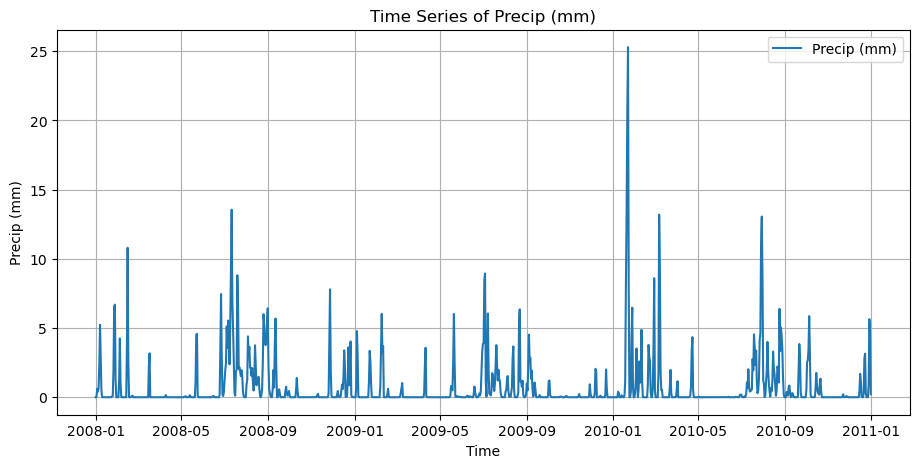

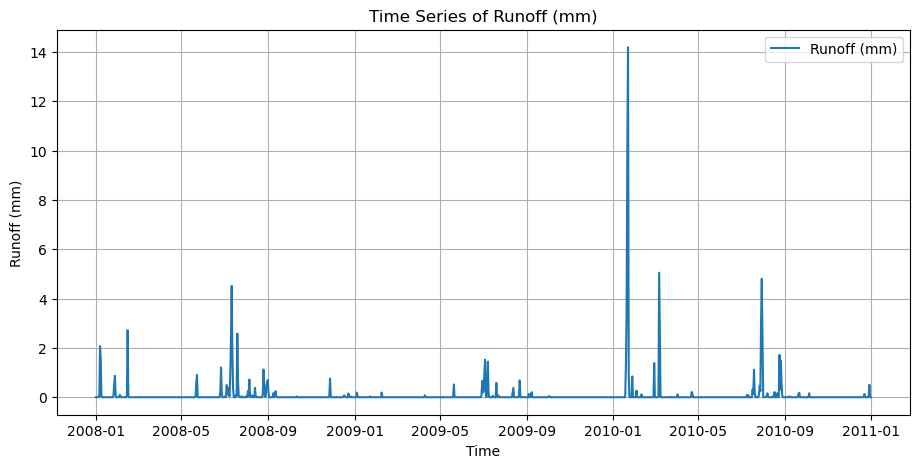

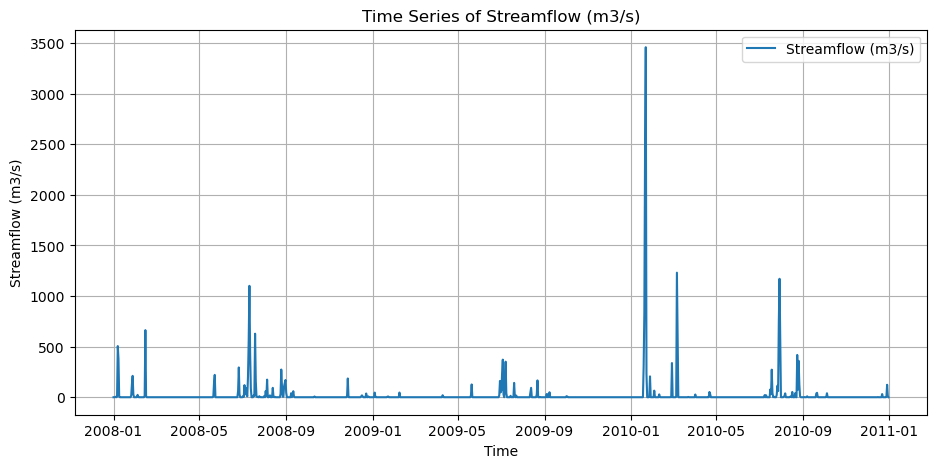

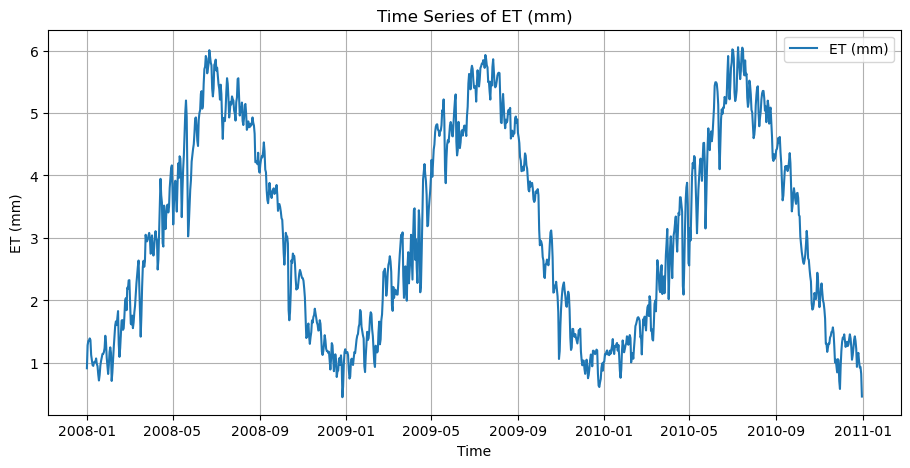

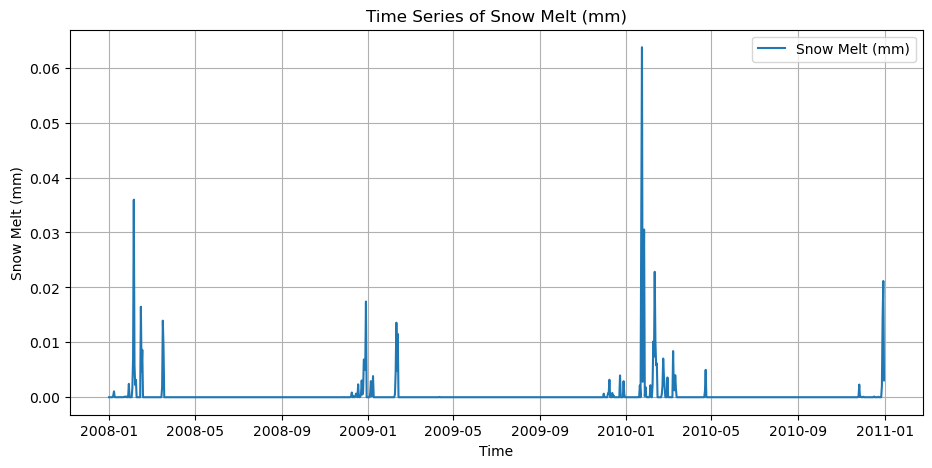

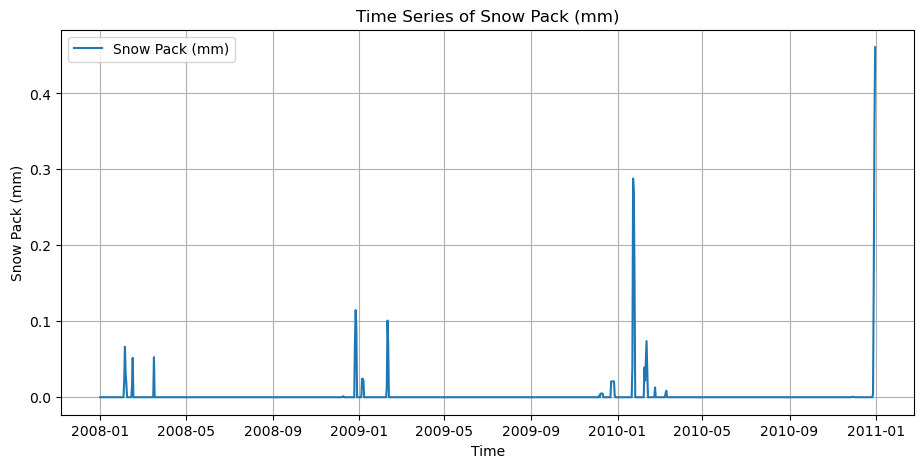

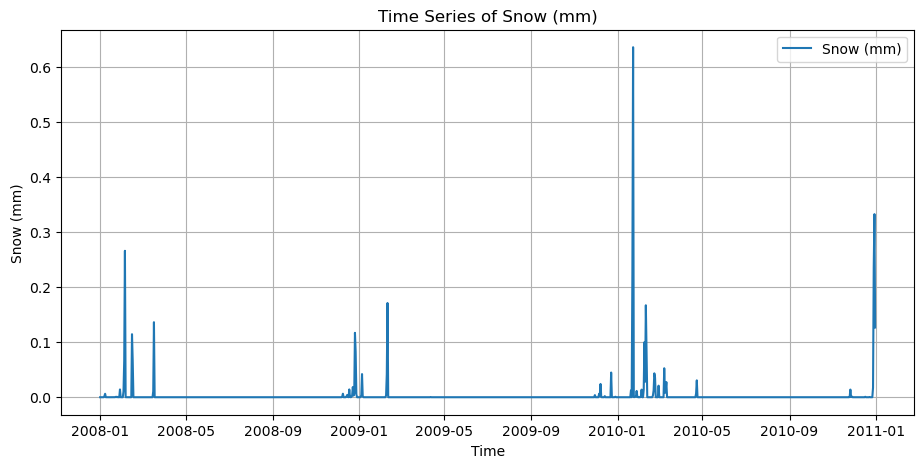

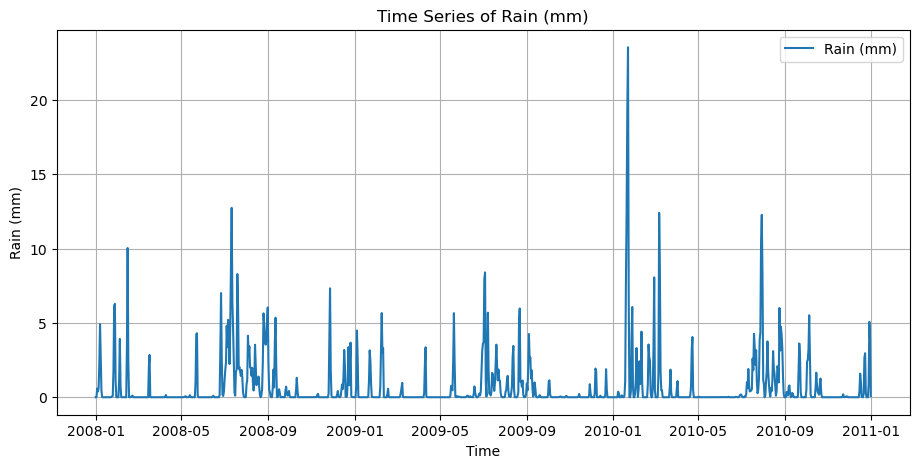

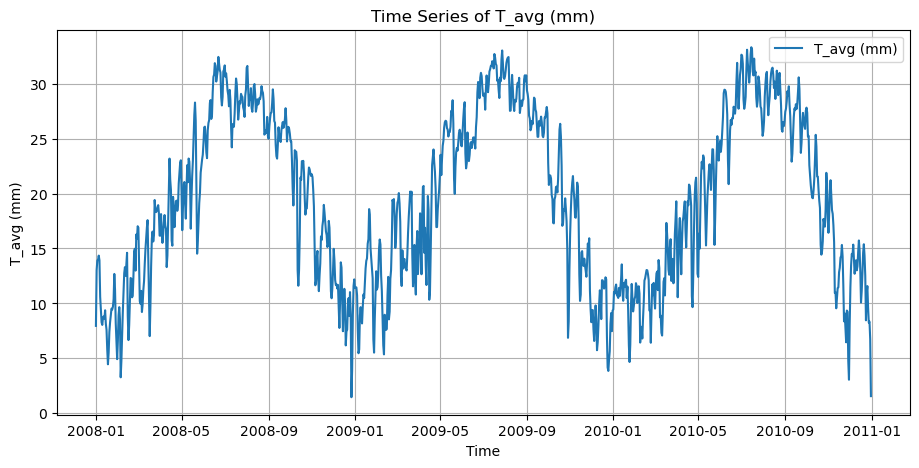

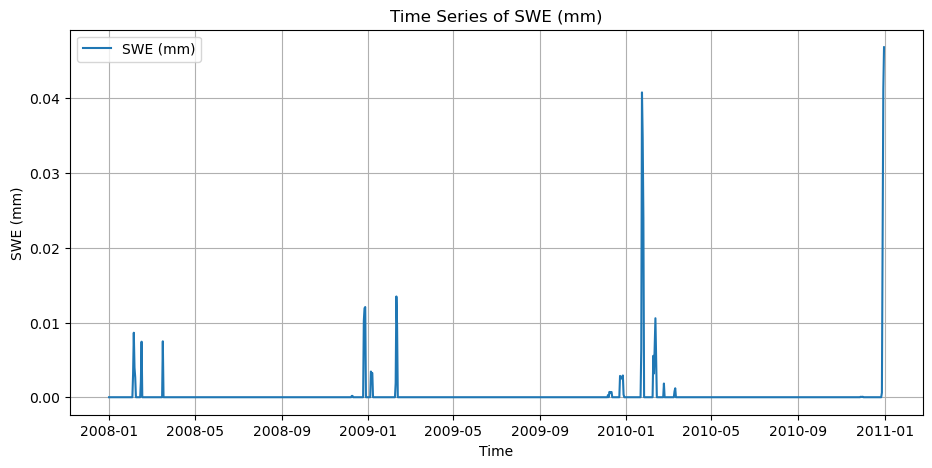

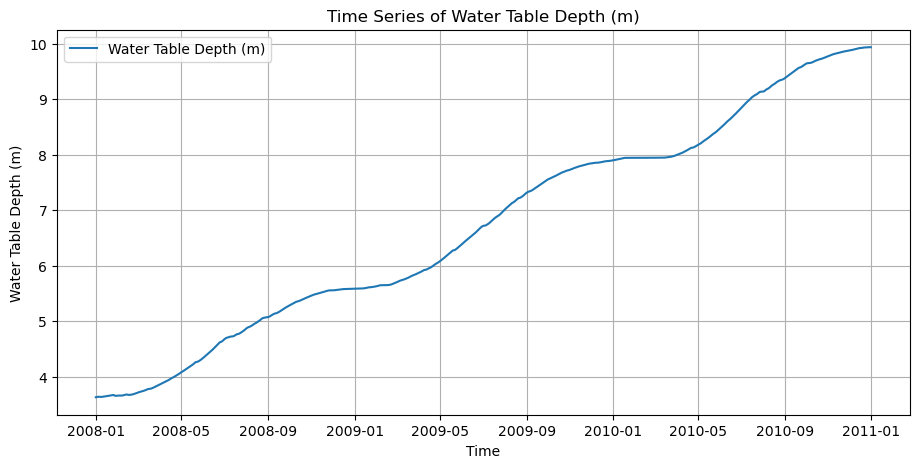

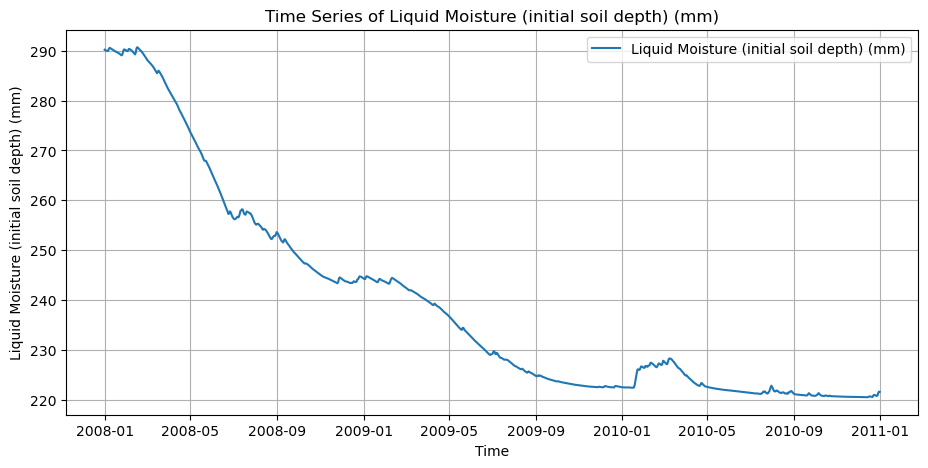

In [95]:
columns = ['Precip (mm)',
        'Runoff (mm)',
        'Streamflow (m3/s)',
        'ET (mm)',
        'Snow Melt (mm)',
        'Snow Pack (mm)',
        'Snow (mm)',
        'Rain (mm)',
        'T_avg (mm)',
        'SWE (mm)',
        'Water Table Depth (m)',
        'Liquid Moisture (initial soil depth) (mm)']
plot_time_series(ts_df, columns)

In [96]:
# Save the model 
model.to_netcdf(f'{save_output_dir}/{location}/{location}_model.nc')
# Save the dataframe 
ts_df.to_csv(f'{save_output_dir}/{location}/{location}_time_series.csv')